In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 3
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [11]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_pr_cls = discriminator(y_pr)
        x_cls = discriminator(x)
        
        # adversarial loss
        _gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))
        _dis = nn.CrossEntropyLoss()(y_cls.float(), torch.ones(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(x_cls.float(), torch.zeros(x_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), 2 * torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device) )
        
        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + _dis + air_loss + bone_loss
                        
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        _loss.backward()
        
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()

    return  air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [12]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        x_cls = discriminator(x)
        x_cls = Activation(name=DIS_ACT)(x_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        total = x.size()[0]
        _, predicted = torch.max(y_cls.data, 1)
        correct = (predicted == torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(y_pr_cls.data, 1)
        correct = (predicted == 2 * torch.ones(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]
        _, predicted = torch.max(x_cls.data, 1)
        correct = (predicted == torch.zeros(total, dtype=torch.long, device=predicted.device)).sum().item()
        acc_ += [correct / total]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [13]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, air_y, bone_x, bone_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (-500))/(500-(-500))
        lower = ((255) - (-500))/(500-(-500))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# Read Data

In [15]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [16]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [17]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [18]:
len(trainset), len(testset)

(1344, 191)

In [19]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7ff89f6cfa90>,)

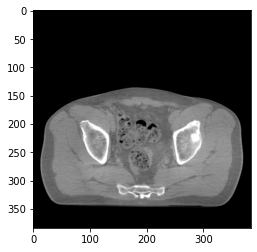

In [20]:
plt.imshow(x.squeeze(), 'gray'),

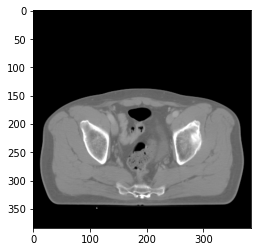

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [23]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [25]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [26]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [28]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:40,  1.05it/s]
168it [00:47,  3.51it/s]
24it [00:07,  3.37it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.35it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.37it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:47,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.50it/s]
24it [00:07,  3.36it/s]
168it [02:40,  1.04it/s]
168it [00:48,  3.49it/s]
24it [00:07,  3.36it/s]
168it [02:41,  1.04it/s]
168it [00:48,

In [29]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [30]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [31]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.3117028772830963
psnr score = 22.287769317626953
snr score = 12.350707054138184
mae error = 0.05559726059436798
air dice score = 0.999121107404671
bone dice score = 0.9764435507041591


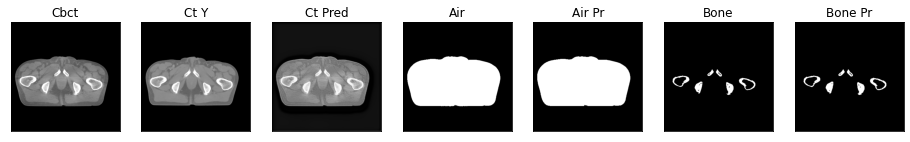

ssim score = 0.31246280670166016
psnr score = 22.23749542236328
snr score = 12.347970962524414
mae error = 0.05566855147480965
air dice score = 0.9990324672086189
bone dice score = 0.9761189761193176


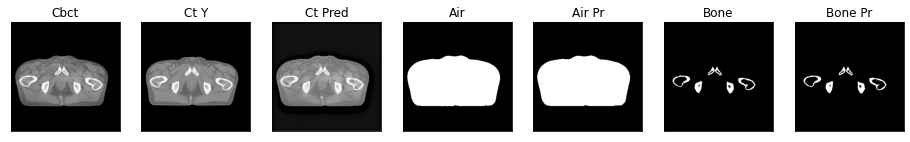

ssim score = 0.309661328792572
psnr score = 22.19797134399414
snr score = 12.471342086791992
mae error = 0.05652405694127083
air dice score = 0.9992415018263845
bone dice score = 0.9749821300932214


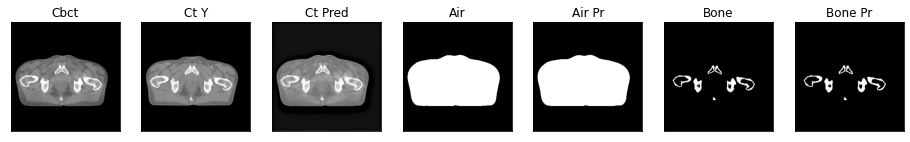

ssim score = 0.30870896577835083
psnr score = 22.27099609375
snr score = 12.633618354797363
mae error = 0.056486018002033234
air dice score = 0.9990205289143872
bone dice score = 0.9672410125508696


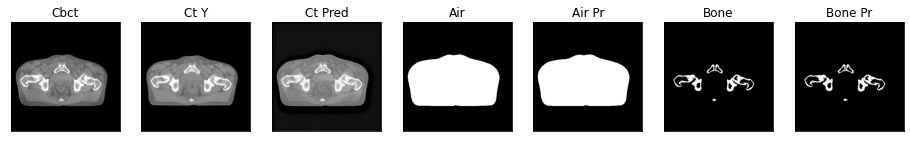

ssim score = 0.30664774775505066
psnr score = 22.374067306518555
snr score = 12.77699089050293
mae error = 0.05595073476433754
air dice score = 0.9989070380731794
bone dice score = 0.9680739540649188


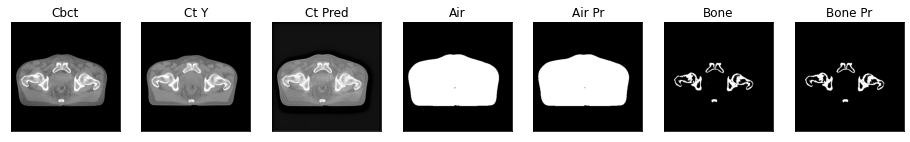

ssim score = 0.2991393804550171
psnr score = 22.3538818359375
snr score = 12.893341064453125
mae error = 0.05654124543070793
air dice score = 0.9990534879974232
bone dice score = 0.9654009793693072


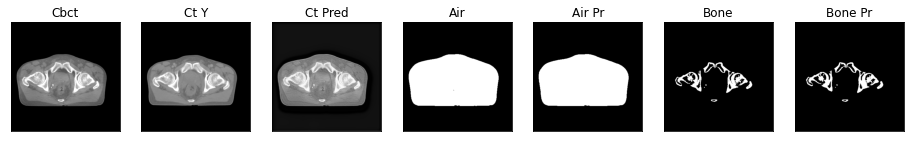

ssim score = 0.2972797751426697
psnr score = 22.29764747619629
snr score = 12.81304931640625
mae error = 0.05699692294001579
air dice score = 0.9990061859851952
bone dice score = 0.9684911357128707


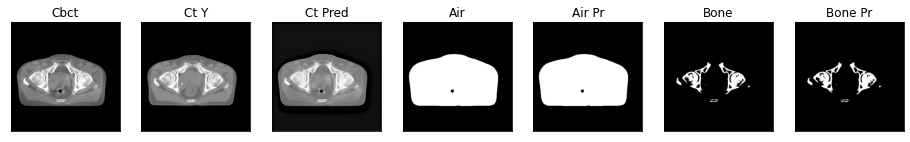

ssim score = 0.29689592123031616
psnr score = 22.464309692382812
snr score = 12.794172286987305
mae error = 0.056251659989356995
air dice score = 0.9990821758551071
bone dice score = 0.973405628711822


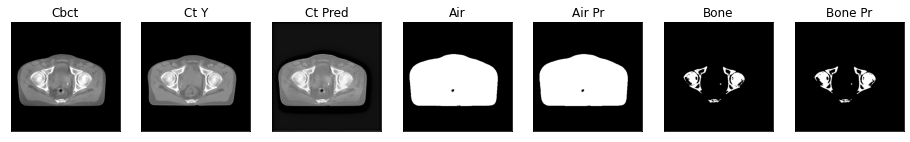

1it [00:02,  2.79s/it]

ssim score = 0.2980562746524811
psnr score = 22.641101837158203
snr score = 12.876410484313965
mae error = 0.0557137206196785
air dice score = 0.9991487266797272
bone dice score = 0.9748279438109284


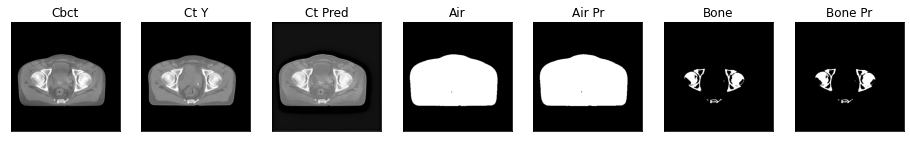

ssim score = 0.29986533522605896
psnr score = 22.688560485839844
snr score = 12.908588409423828
mae error = 0.05577968433499336
air dice score = 0.9990588770645248
bone dice score = 0.9741935483873491


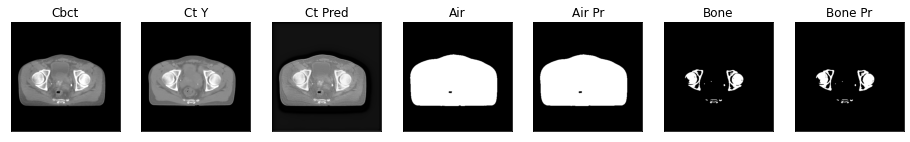

ssim score = 0.30502718687057495
psnr score = 22.78720474243164
snr score = 13.039498329162598
mae error = 0.05574740469455719
air dice score = 0.9991986095355065
bone dice score = 0.9793016934980211


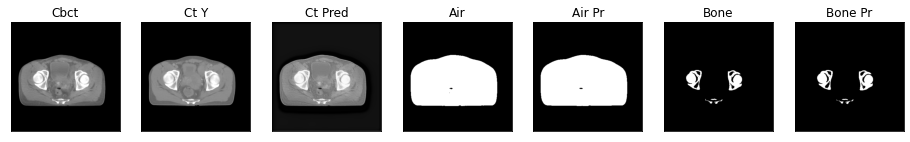

ssim score = 0.3034120202064514
psnr score = 22.47565460205078
snr score = 12.75166130065918
mae error = 0.05685112997889519
air dice score = 0.9989369428159449
bone dice score = 0.981711777615407


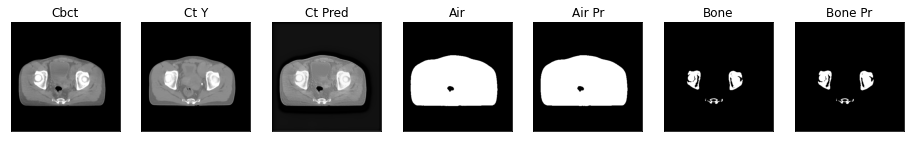

ssim score = 0.3049786388874054
psnr score = 22.162334442138672
snr score = 12.40641975402832
mae error = 0.05776737257838249
air dice score = 0.9989779187871314
bone dice score = 0.9823813264506522


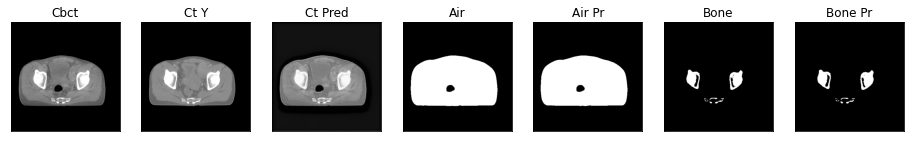

ssim score = 0.3024120330810547
psnr score = 22.08298683166504
snr score = 12.185113906860352
mae error = 0.05746478587388992
air dice score = 0.9988944108712698
bone dice score = 0.9712895377132446


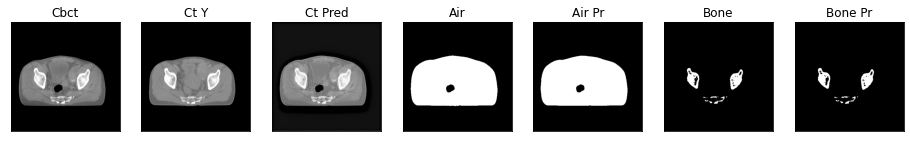

ssim score = 0.2981223165988922
psnr score = 22.023677825927734
snr score = 12.040143966674805
mae error = 0.05768230929970741
air dice score = 0.9987678606169357
bone dice score = 0.9654818426797706


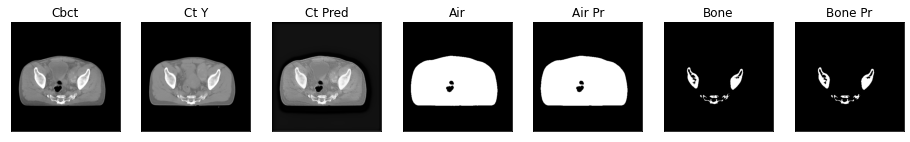

ssim score = 0.2913987338542938
psnr score = 21.836353302001953
snr score = 11.876304626464844
mae error = 0.05848625674843788
air dice score = 0.9990660498251569
bone dice score = 0.9679715302495033


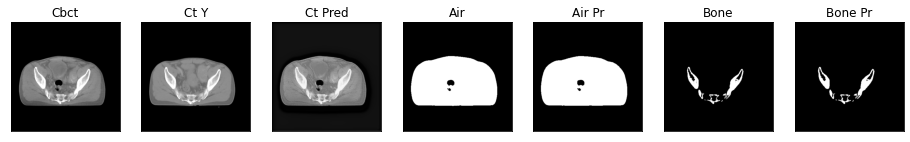

2it [00:04,  2.57s/it]

ssim score = 0.286298930644989
psnr score = 21.413829803466797
snr score = 11.451238632202148
mae error = 0.06010984629392624
air dice score = 0.9990983858908397
bone dice score = 0.9641988182138316


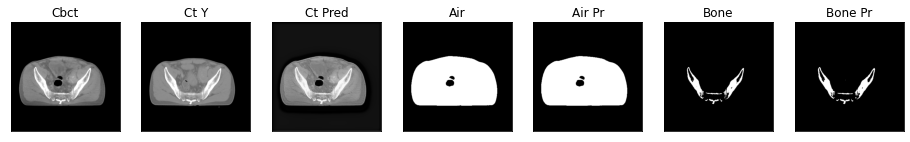

ssim score = 0.2755400836467743
psnr score = 21.049394607543945
snr score = 10.985041618347168
mae error = 0.06139972433447838
air dice score = 0.9984286016783889
bone dice score = 0.9547527183449694


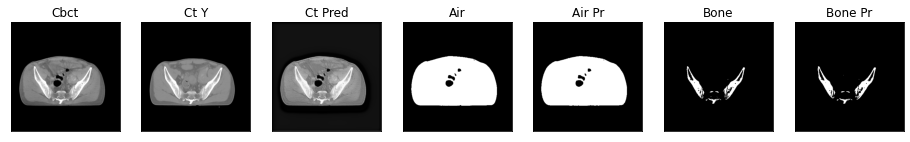

ssim score = 0.270154744386673
psnr score = 20.87251853942871
snr score = 10.757484436035156
mae error = 0.06207418441772461
air dice score = 0.9983350208122417
bone dice score = 0.9498915648904247


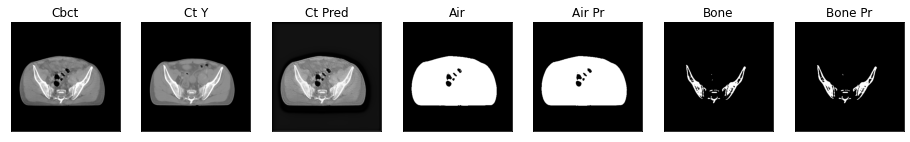

ssim score = 0.2687663733959198
psnr score = 20.822980880737305
snr score = 10.695634841918945
mae error = 0.06239524111151695
air dice score = 0.9984844372059373
bone dice score = 0.9568720379152028


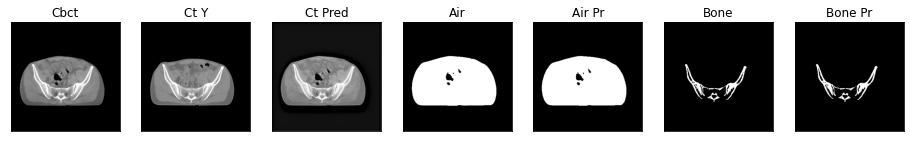

ssim score = 0.26007622480392456
psnr score = 20.735387802124023
snr score = 10.543195724487305
mae error = 0.06282126903533936
air dice score = 0.998725621828279
bone dice score = 0.9527620030981833


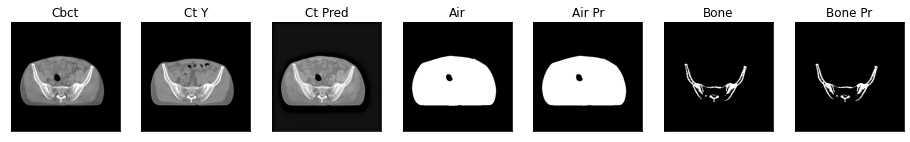

ssim score = 0.25377750396728516
psnr score = 20.679025650024414
snr score = 10.42740249633789
mae error = 0.06298690289258957
air dice score = 0.9986541049798131
bone dice score = 0.9555357370371317


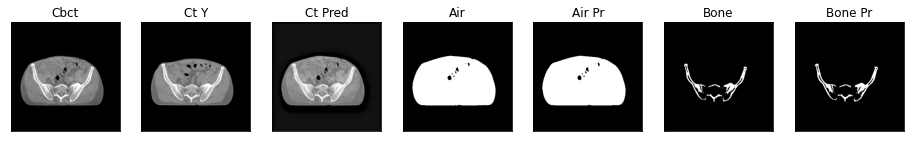

ssim score = 0.25486376881599426
psnr score = 20.761367797851562
snr score = 10.476320266723633
mae error = 0.06275801360607147
air dice score = 0.9986910236658303
bone dice score = 0.9559070213281102


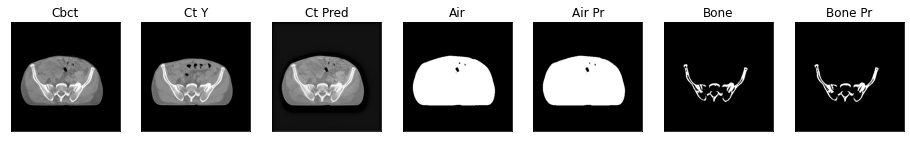

ssim score = 0.25138887763023376
psnr score = 20.748586654663086
snr score = 10.414974212646484
mae error = 0.06339283287525177
air dice score = 0.9987827145465626
bone dice score = 0.9587971995872971


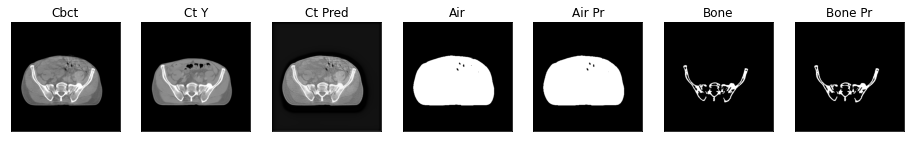

3it [00:07,  2.49s/it]

ssim score = 0.24848361313343048
psnr score = 20.71303367614746
snr score = 10.28242015838623
mae error = 0.06393884122371674
air dice score = 0.998979930730181
bone dice score = 0.9618456078087639


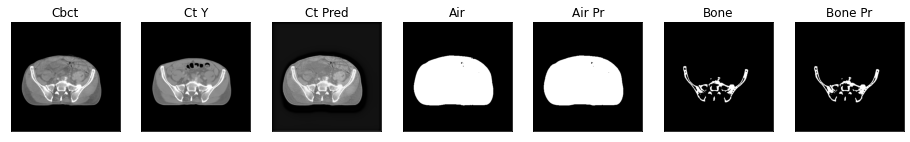

ssim score = 0.24597840011119843
psnr score = 20.83310890197754
snr score = 10.319759368896484
mae error = 0.06366048753261566
air dice score = 0.9988732053068409
bone dice score = 0.9580089902427584


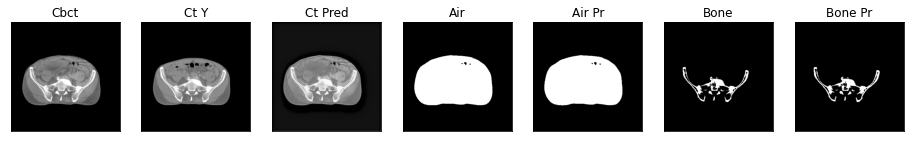

ssim score = 0.23774681985378265
psnr score = 20.89922332763672
snr score = 10.29469108581543
mae error = 0.06391288340091705
air dice score = 0.9989005694803043
bone dice score = 0.9637494637498525


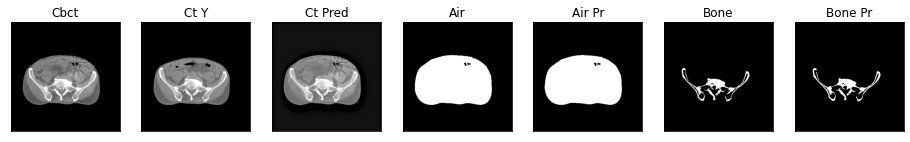

ssim score = 0.230640709400177
psnr score = 20.816373825073242
snr score = 10.170732498168945
mae error = 0.06437380611896515
air dice score = 0.9986062805268529
bone dice score = 0.9579900315333334


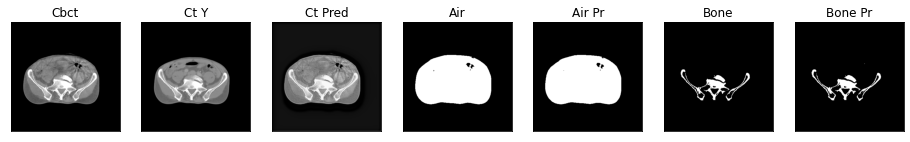

ssim score = 0.477833092212677
psnr score = 22.04848861694336
snr score = 13.420644760131836
mae error = 0.049442194402217865
air dice score = 0.9991814086020838
bone dice score = 0.9870784746300952


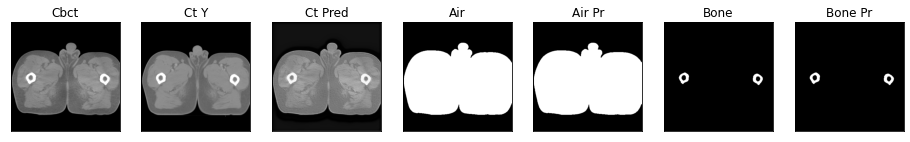

ssim score = 0.49212437868118286
psnr score = 22.48324203491211
snr score = 13.894655227661133
mae error = 0.047635454684495926
air dice score = 0.9990956168388717
bone dice score = 0.9902855460703478


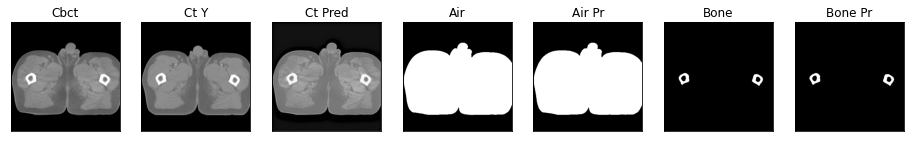

ssim score = 0.4947970509529114
psnr score = 22.849010467529297
snr score = 14.34787368774414
mae error = 0.04659675434231758
air dice score = 0.9993294824711958
bone dice score = 0.9856148491882688


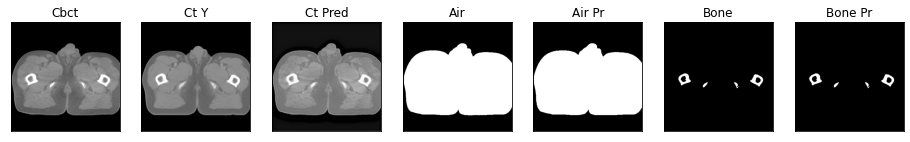

ssim score = 0.5043727159500122
psnr score = 23.072872161865234
snr score = 14.734292984008789
mae error = 0.045954134315252304
air dice score = 0.9991563863994821
bone dice score = 0.9844985764001186


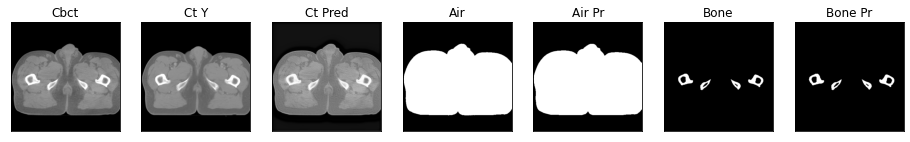

4it [00:09,  2.36s/it]

ssim score = 0.5081998705863953
psnr score = 23.258039474487305
snr score = 15.047602653503418
mae error = 0.04534204676747322
air dice score = 0.9992754814395397
bone dice score = 0.9803547066851248


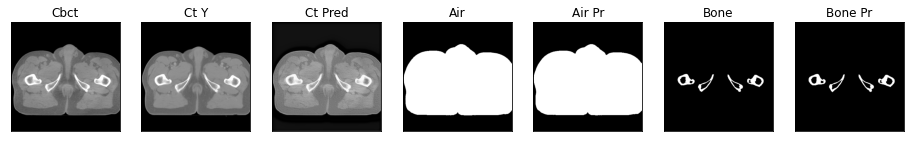

ssim score = 0.5137432217597961
psnr score = 23.54595375061035
snr score = 15.438755989074707
mae error = 0.044593486934900284
air dice score = 0.9990723393419072
bone dice score = 0.97926294584691


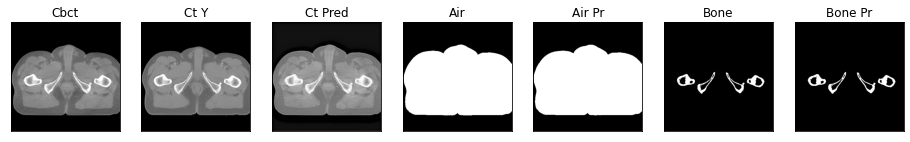

ssim score = 0.5131455063819885
psnr score = 23.73128890991211
snr score = 15.691193580627441
mae error = 0.04480403661727905
air dice score = 0.9990213609124305
bone dice score = 0.97442566103192


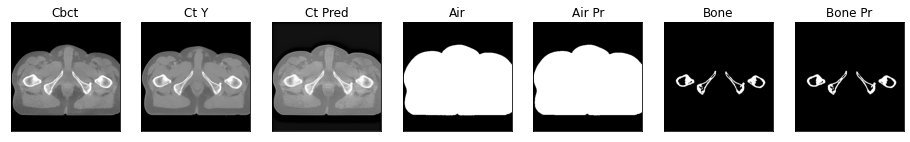

ssim score = 0.5139663815498352
psnr score = 23.67957878112793
snr score = 15.629594802856445
mae error = 0.04498860612511635
air dice score = 0.9991148151047474
bone dice score = 0.9786096256686692


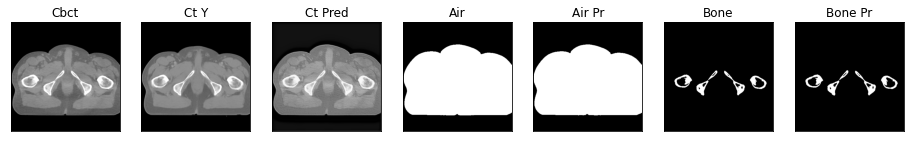

ssim score = 0.5188389420509338
psnr score = 23.798053741455078
snr score = 15.734400749206543
mae error = 0.044434186071157455
air dice score = 0.9991164962766634
bone dice score = 0.9819105691058749


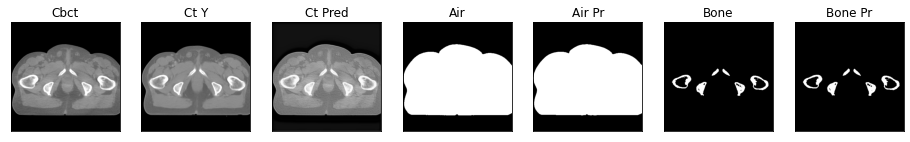

ssim score = 0.516177773475647
psnr score = 23.763774871826172
snr score = 15.71212387084961
mae error = 0.04467882215976715
air dice score = 0.999123723096499
bone dice score = 0.9786096256686779


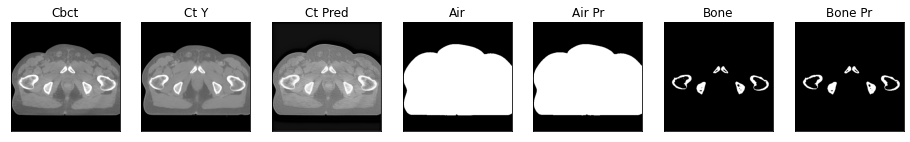

ssim score = 0.5190901756286621
psnr score = 23.80901336669922
snr score = 15.796446800231934
mae error = 0.04431871324777603
air dice score = 0.9991482623352013
bone dice score = 0.9784520668428051


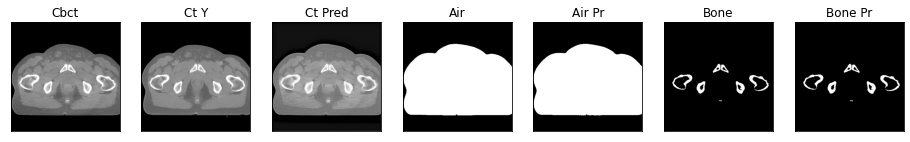

ssim score = 0.5133115649223328
psnr score = 23.82880401611328
snr score = 15.957527160644531
mae error = 0.0447724349796772
air dice score = 0.9991842316782039
bone dice score = 0.9735707591380172


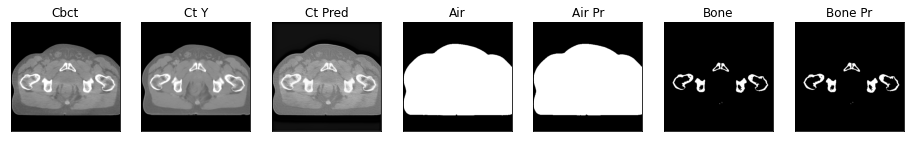

5it [00:11,  2.34s/it]

ssim score = 0.5167276263237
psnr score = 23.920068740844727
snr score = 16.143478393554688
mae error = 0.04488262161612511
air dice score = 0.9990449590053163
bone dice score = 0.9801571862113442


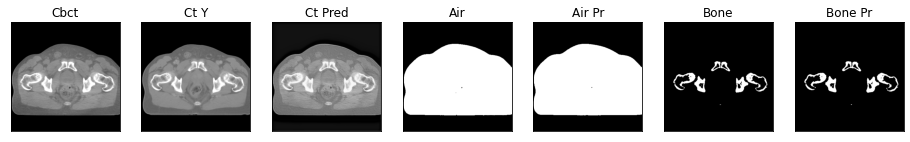

ssim score = 0.5072181224822998
psnr score = 23.560998916625977
snr score = 15.750362396240234
mae error = 0.04644060879945755
air dice score = 0.9991614837514861
bone dice score = 0.9690458302030875


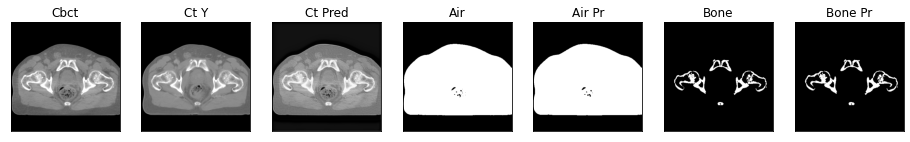

ssim score = 0.5105642080307007
psnr score = 23.360422134399414
snr score = 15.621971130371094
mae error = 0.046553175896406174
air dice score = 0.9986876959342884
bone dice score = 0.9650837988829032


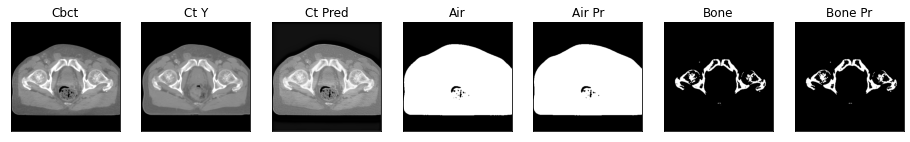

ssim score = 0.504938542842865
psnr score = 23.423864364624023
snr score = 15.549321174621582
mae error = 0.04638267308473587
air dice score = 0.9990313442383265
bone dice score = 0.9576488070671374


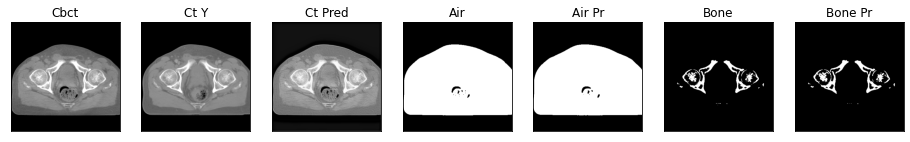

ssim score = 0.5124585628509521
psnr score = 23.469419479370117
snr score = 15.416315078735352
mae error = 0.04567527025938034
air dice score = 0.9992488687230162
bone dice score = 0.9606255235971272


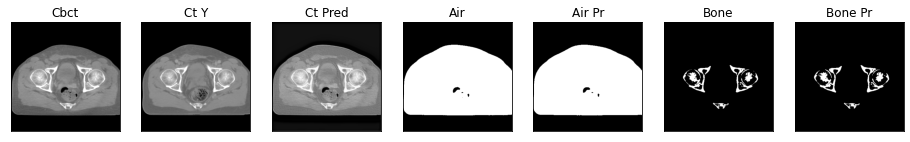

ssim score = 0.5062981843948364
psnr score = 23.562904357910156
snr score = 15.419208526611328
mae error = 0.045848775655031204
air dice score = 0.9991562935609308
bone dice score = 0.9586430740240954


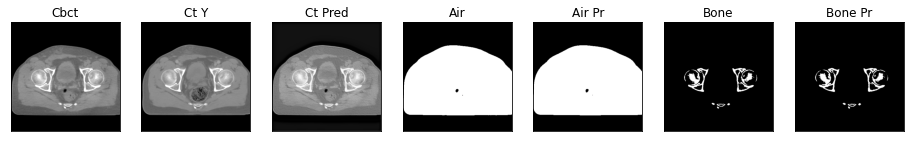

ssim score = 0.5061042904853821
psnr score = 23.559940338134766
snr score = 15.431936264038086
mae error = 0.04548397287726402
air dice score = 0.9993619475324552
bone dice score = 0.9670329670332904


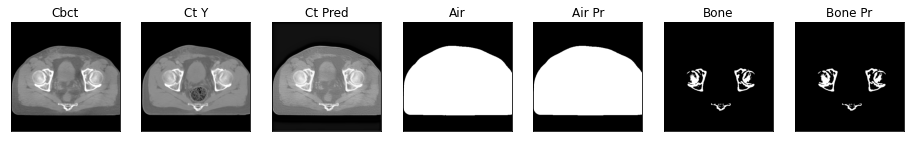

ssim score = 0.48664915561676025
psnr score = 23.348011016845703
snr score = 15.23004150390625
mae error = 0.0468238890171051
air dice score = 0.999278245581568
bone dice score = 0.9673537998764279


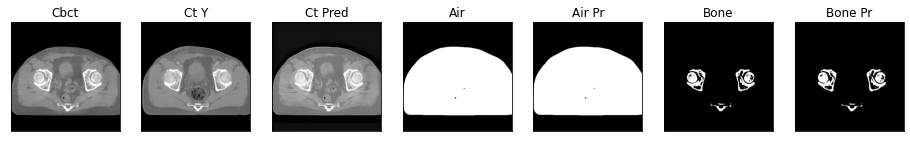

6it [00:13,  2.33s/it]

ssim score = 0.4976534843444824
psnr score = 23.564088821411133
snr score = 15.507708549499512
mae error = 0.04638553038239479
air dice score = 0.9991763838918034
bone dice score = 0.979400260756372


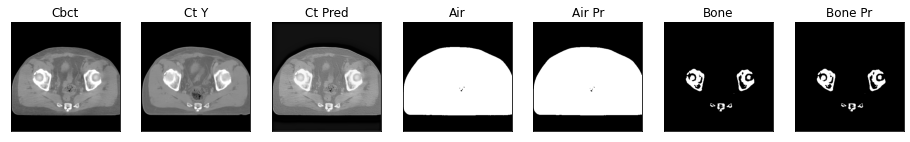

ssim score = 0.48959678411483765
psnr score = 23.72610092163086
snr score = 15.7398042678833
mae error = 0.04653208702802658
air dice score = 0.9991742464222524
bone dice score = 0.9825724730087344


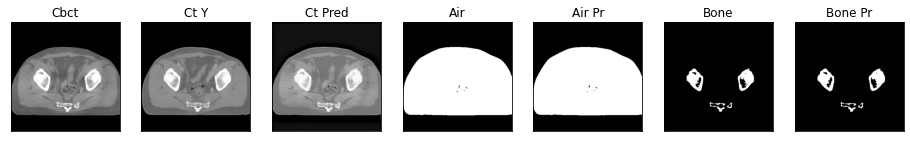

ssim score = 0.4953351318836212
psnr score = 23.388290405273438
snr score = 15.28288745880127
mae error = 0.04741469770669937
air dice score = 0.9990314409178966
bone dice score = 0.9769628584863473


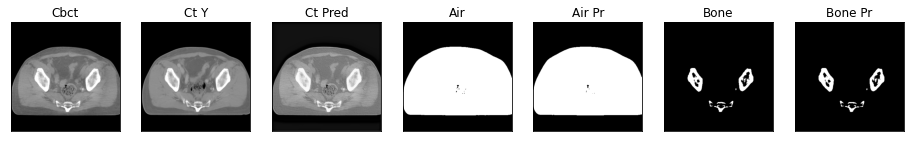

ssim score = 0.489580363035202
psnr score = 23.002098083496094
snr score = 14.978322982788086
mae error = 0.048979051411151886
air dice score = 0.9989070631046867
bone dice score = 0.9781680892976184


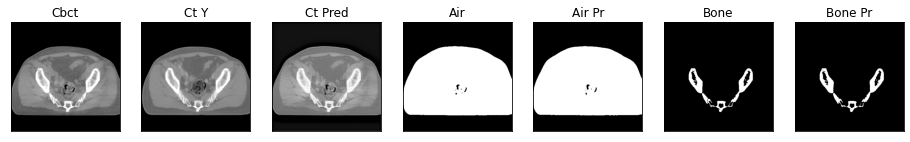

ssim score = 0.49734920263290405
psnr score = 23.045557022094727
snr score = 15.101926803588867
mae error = 0.048713698983192444
air dice score = 0.9990940342777721
bone dice score = 0.9774281805747098


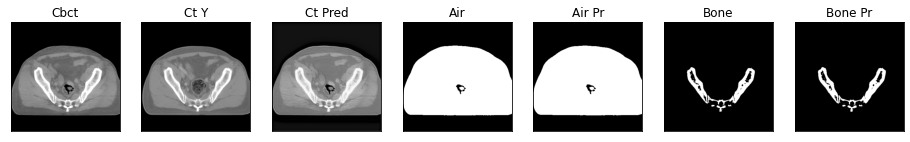

ssim score = 0.480978399515152
psnr score = 22.794132232666016
snr score = 14.87205982208252
mae error = 0.05018759146332741
air dice score = 0.9990043844189259
bone dice score = 0.972347707050155


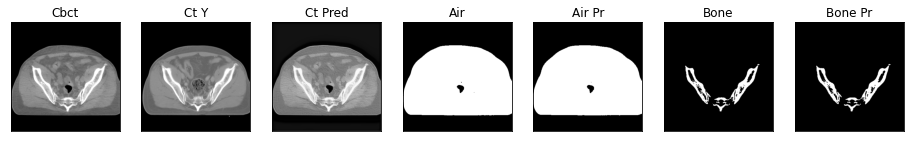

ssim score = 0.4831032156944275
psnr score = 23.076213836669922
snr score = 15.166681289672852
mae error = 0.04910147935152054
air dice score = 0.9988958410011048
bone dice score = 0.9771555927010924


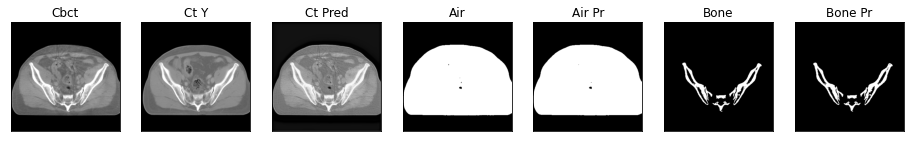

ssim score = 0.26795023679733276
psnr score = 19.7917537689209
snr score = 9.67196273803711
mae error = 0.06957338750362396
air dice score = 0.993621188100351
bone dice score = 0.9785384406417131


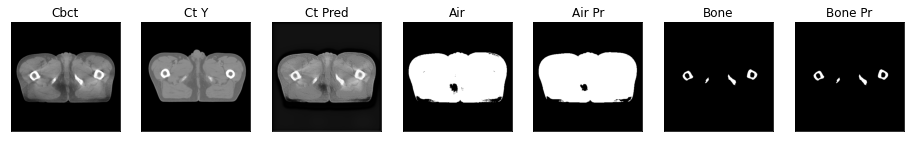

7it [00:15,  2.26s/it]

ssim score = 0.2602757513523102
psnr score = 19.560190200805664
snr score = 9.6533784866333
mae error = 0.07109757512807846
air dice score = 0.9932564675763232
bone dice score = 0.971614301192381


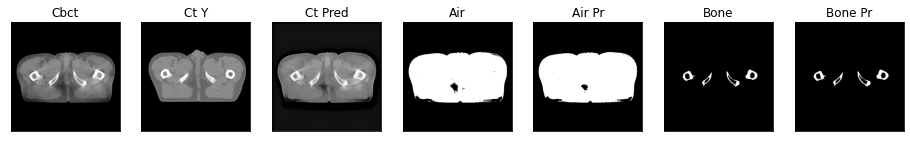

ssim score = 0.2602096498012543
psnr score = 19.59735679626465
snr score = 9.821685791015625
mae error = 0.07091597467660904
air dice score = 0.9932523367932069
bone dice score = 0.9544990818209651


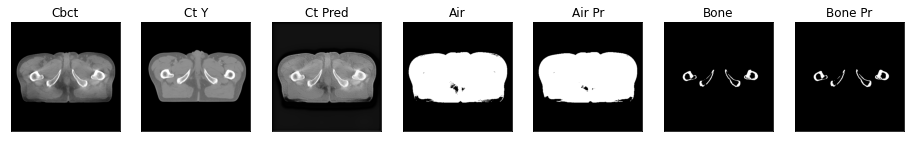

ssim score = 0.2645829916000366
psnr score = 19.821922302246094
snr score = 10.116652488708496
mae error = 0.06960315257310867
air dice score = 0.9937906564163275
bone dice score = 0.9528301886801723


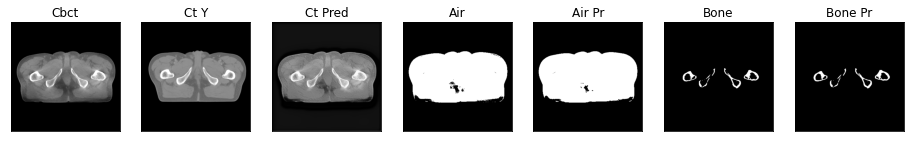

ssim score = 0.26745620369911194
psnr score = 19.899600982666016
snr score = 10.241897583007812
mae error = 0.06935910880565643
air dice score = 0.9931494882805738
bone dice score = 0.9520560924776946


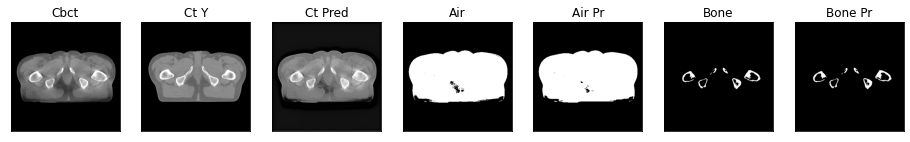

ssim score = 0.2720494568347931
psnr score = 20.055683135986328
snr score = 10.403595924377441
mae error = 0.06851521879434586
air dice score = 0.9930199495528612
bone dice score = 0.9587172871367726


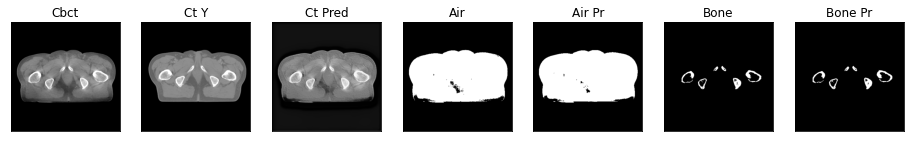

ssim score = 0.27943184971809387
psnr score = 20.179841995239258
snr score = 10.52125072479248
mae error = 0.0676044225692749
air dice score = 0.993846771837575
bone dice score = 0.9617691154429954


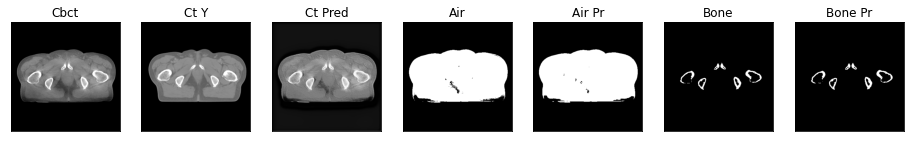

ssim score = 0.2823130786418915
psnr score = 20.151836395263672
snr score = 10.507355690002441
mae error = 0.06753193587064743
air dice score = 0.9950043972184239
bone dice score = 0.9620991253651221


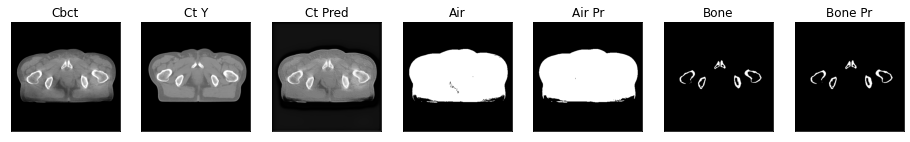

ssim score = 0.2833039164543152
psnr score = 20.128421783447266
snr score = 10.541949272155762
mae error = 0.06818850338459015
air dice score = 0.9956909401338828
bone dice score = 0.9536811311562867


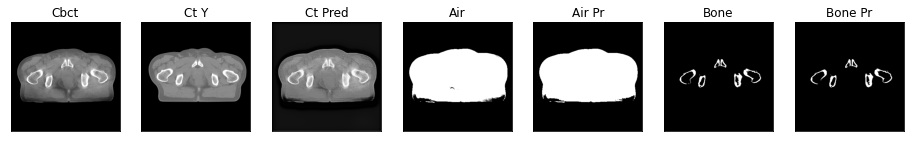

8it [00:18,  2.26s/it]

ssim score = 0.27888256311416626
psnr score = 19.997434616088867
snr score = 10.509520530700684
mae error = 0.06963220238685608
air dice score = 0.996283802067364
bone dice score = 0.9504497636842438


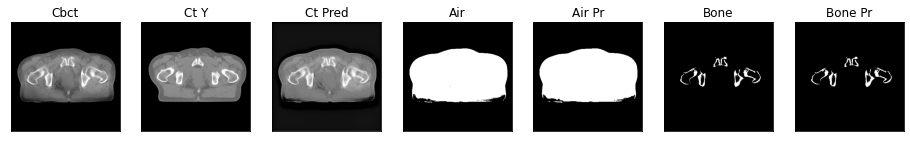

ssim score = 0.27068644762039185
psnr score = 19.90374755859375
snr score = 10.451661109924316
mae error = 0.0706486776471138
air dice score = 0.9952997532820731
bone dice score = 0.9436865021778855


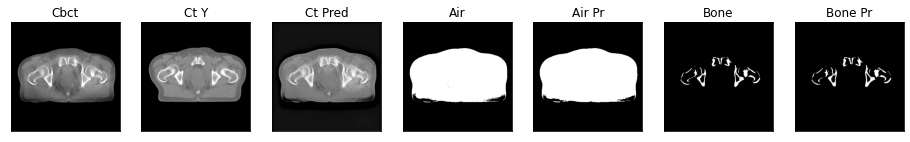

ssim score = 0.259330153465271
psnr score = 19.796964645385742
snr score = 10.377584457397461
mae error = 0.07104330509901047
air dice score = 0.9954061221737803
bone dice score = 0.9256092892698021


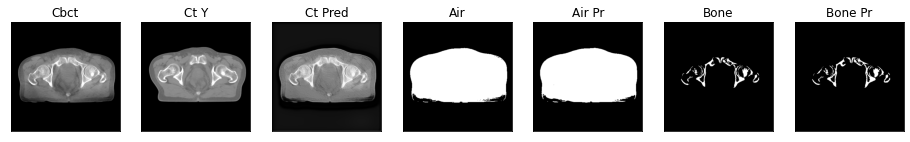

ssim score = 0.2600826919078827
psnr score = 19.7741756439209
snr score = 10.471612930297852
mae error = 0.07146092504262924
air dice score = 0.9950790229885101
bone dice score = 0.9389371486977652


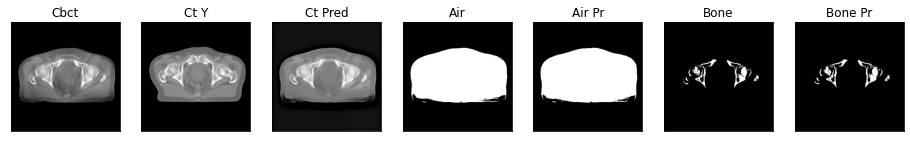

ssim score = 0.2657501697540283
psnr score = 19.743152618408203
snr score = 10.424603462219238
mae error = 0.07140196114778519
air dice score = 0.9943361846888543
bone dice score = 0.932991160537026


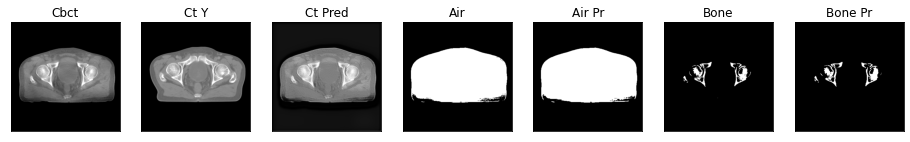

ssim score = 0.2786925733089447
psnr score = 20.15229034423828
snr score = 10.634580612182617
mae error = 0.06818894296884537
air dice score = 0.9938566552901079
bone dice score = 0.948015995079237


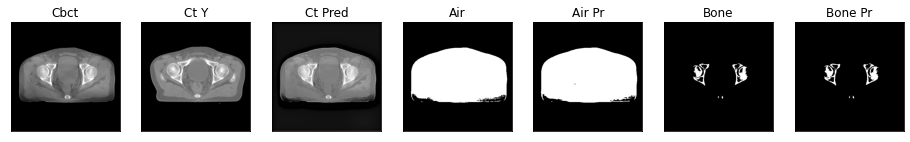

ssim score = 0.29136922955513
psnr score = 20.671009063720703
snr score = 10.982905387878418
mae error = 0.0653747022151947
air dice score = 0.9932475451733012
bone dice score = 0.9634025717116942


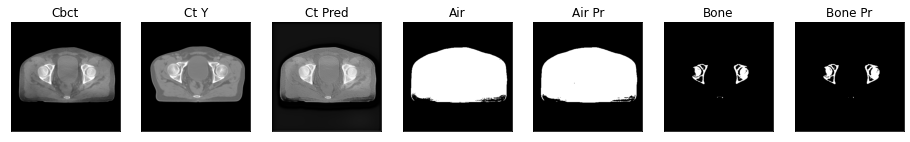

ssim score = 0.29762929677963257
psnr score = 20.917373657226562
snr score = 11.243436813354492
mae error = 0.06390697509050369
air dice score = 0.9935553361457736
bone dice score = 0.9684073107053732


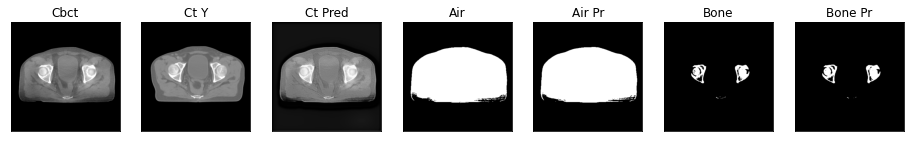

9it [00:20,  2.21s/it]

ssim score = 0.3004904091358185
psnr score = 20.960391998291016
snr score = 11.3682861328125
mae error = 0.06410248577594757
air dice score = 0.9945863309352566
bone dice score = 0.9733032275206096


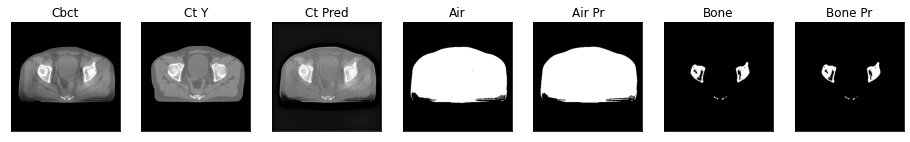

ssim score = 0.29923215508461
psnr score = 20.79387664794922
snr score = 11.293940544128418
mae error = 0.06543324142694473
air dice score = 0.9942181978401469
bone dice score = 0.9615384615390349


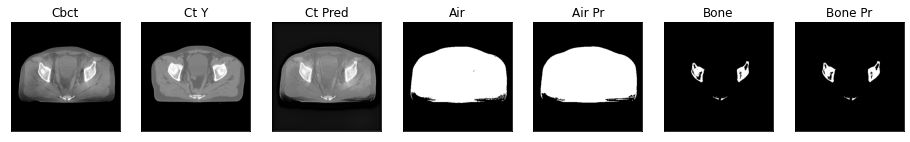

ssim score = 0.2941490709781647
psnr score = 20.99410057067871
snr score = 11.430739402770996
mae error = 0.0644470602273941
air dice score = 0.9935307955517594
bone dice score = 0.9729104724153798


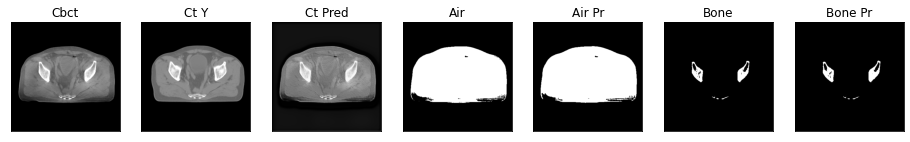

ssim score = 0.29933813214302063
psnr score = 21.202917098999023
snr score = 11.603163719177246
mae error = 0.06307730078697205
air dice score = 0.9931813130639702
bone dice score = 0.9722419928830562


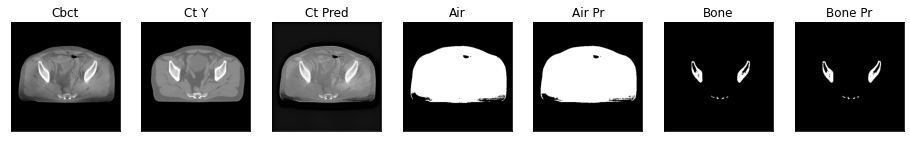

ssim score = 0.3008231818675995
psnr score = 21.114349365234375
snr score = 11.55234146118164
mae error = 0.06376609951257706
air dice score = 0.9930706509684293
bone dice score = 0.9607525137859106


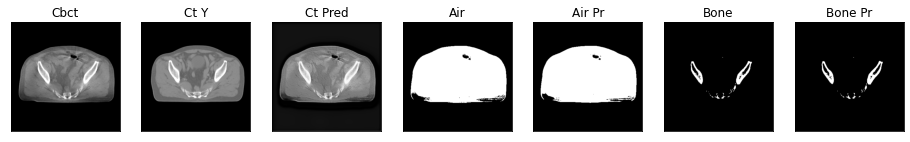

ssim score = 0.2986408770084381
psnr score = 21.127302169799805
snr score = 11.695796966552734
mae error = 0.06399635225534439
air dice score = 0.992702410684244
bone dice score = 0.9542391914661111


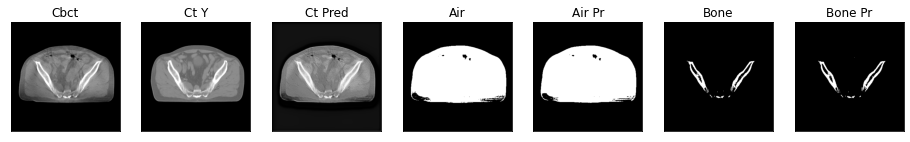

ssim score = 0.2981031835079193
psnr score = 21.094337463378906
snr score = 11.680582046508789
mae error = 0.06421411782503128
air dice score = 0.9922722715617888
bone dice score = 0.93788063337488


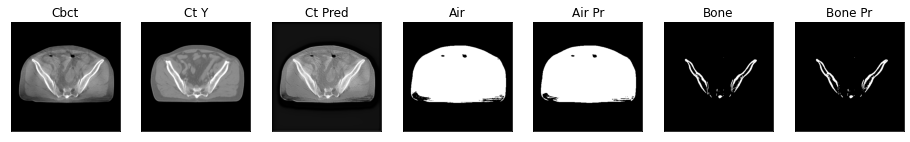

ssim score = 0.2987339496612549
psnr score = 21.350788116455078
snr score = 11.925765037536621
mae error = 0.06329494714736938
air dice score = 0.992239931021616
bone dice score = 0.9429140391645716


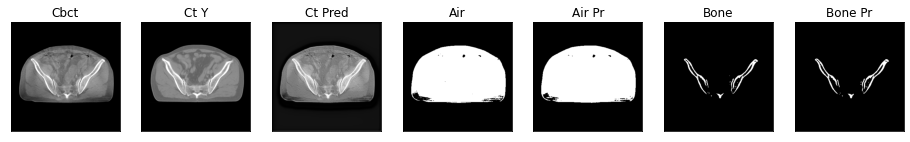

10it [00:22,  2.23s/it]

ssim score = 0.3004225194454193
psnr score = 21.39852523803711
snr score = 11.972760200500488
mae error = 0.06301204115152359
air dice score = 0.9917919559385852
bone dice score = 0.9410640331325093


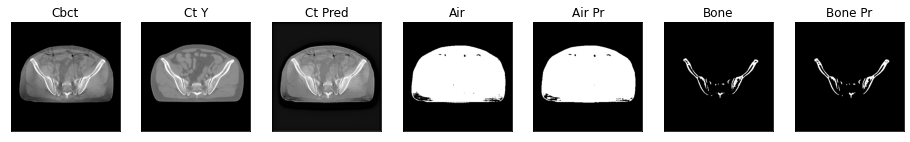

ssim score = 0.40284040570259094
psnr score = 22.43206214904785
snr score = 12.866196632385254
mae error = 0.05308036133646965
air dice score = 0.9992106958762893
bone dice score = 0.9760729206237724


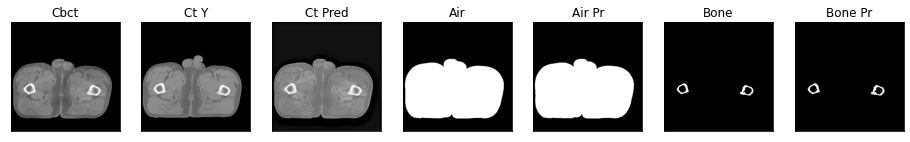

ssim score = 0.40048864483833313
psnr score = 22.596145629882812
snr score = 13.094669342041016
mae error = 0.052639078348875046
air dice score = 0.9989823962565011
bone dice score = 0.9647223192467789


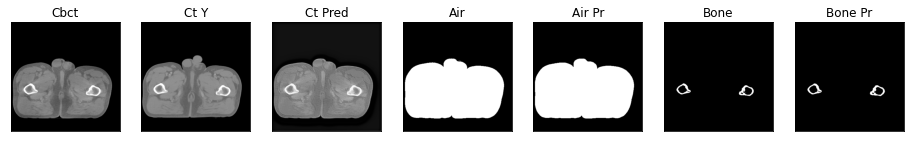

ssim score = 0.4074360132217407
psnr score = 23.398008346557617
snr score = 14.035747528076172
mae error = 0.051254138350486755
air dice score = 0.9989702480909992
bone dice score = 0.9725101397031881


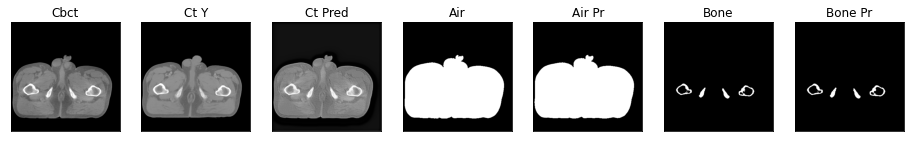

ssim score = 0.40879619121551514
psnr score = 23.20695686340332
snr score = 13.966184616088867
mae error = 0.05172022804617882
air dice score = 0.9990472966056997
bone dice score = 0.9643705463190592


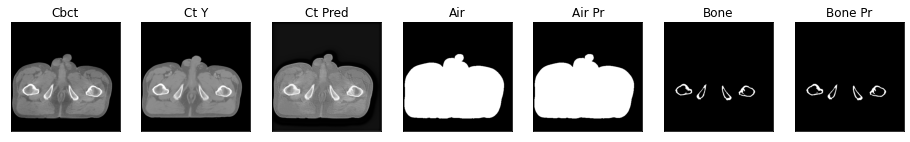

ssim score = 0.4057788550853729
psnr score = 23.072895050048828
snr score = 13.856298446655273
mae error = 0.051689326763153076
air dice score = 0.9989946117473342
bone dice score = 0.9568121104194832


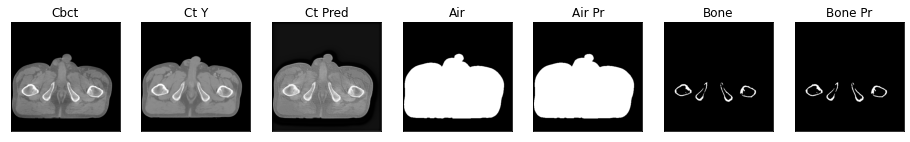

ssim score = 0.4055328965187073
psnr score = 23.039852142333984
snr score = 13.818857192993164
mae error = 0.051383379846811295
air dice score = 0.9992863360808093
bone dice score = 0.9527448220399609


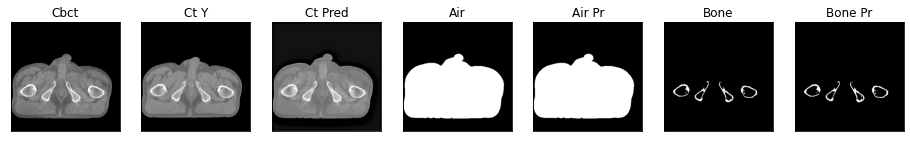

ssim score = 0.4076586961746216
psnr score = 22.78478240966797
snr score = 13.570042610168457
mae error = 0.0521358922123909
air dice score = 0.9987538305993379
bone dice score = 0.9550009825121831


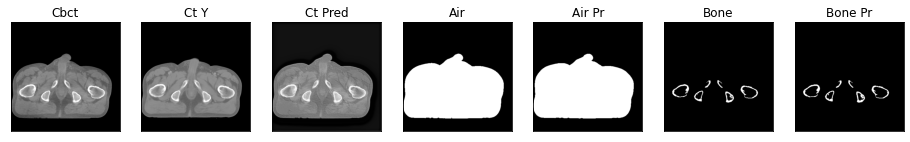

11it [00:24,  2.18s/it]

ssim score = 0.40400561690330505
psnr score = 22.636625289916992
snr score = 13.400330543518066
mae error = 0.05228781700134277
air dice score = 0.9988545426016014
bone dice score = 0.9614254944201797


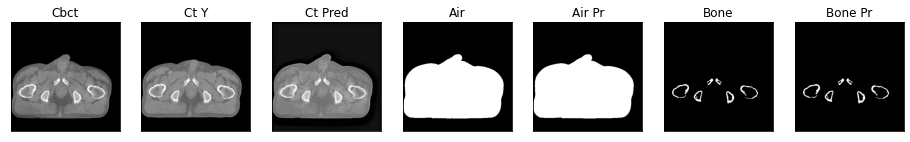

ssim score = 0.4032464027404785
psnr score = 22.679967880249023
snr score = 13.460583686828613
mae error = 0.0522359237074852
air dice score = 0.998906020037936
bone dice score = 0.9643835616444861


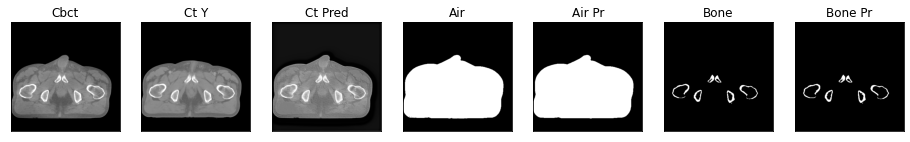

ssim score = 0.40043914318084717
psnr score = 22.866539001464844
snr score = 13.71574878692627
mae error = 0.05189356952905655
air dice score = 0.999044256455219
bone dice score = 0.9615770130310461


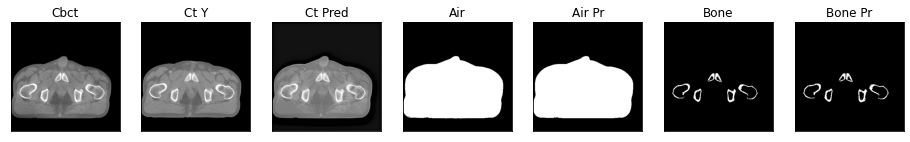

ssim score = 0.402544766664505
psnr score = 23.100067138671875
snr score = 14.030633926391602
mae error = 0.051459986716508865
air dice score = 0.9991910668400856
bone dice score = 0.9610389610395494


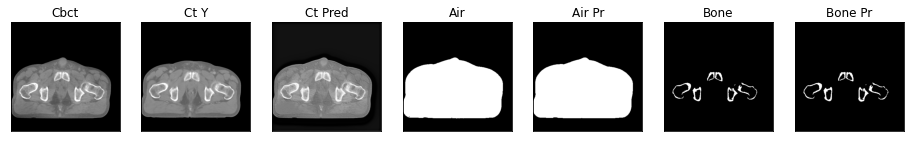

ssim score = 0.40244361758232117
psnr score = 23.400840759277344
snr score = 14.382110595703125
mae error = 0.05070658028125763
air dice score = 0.9991560106374515
bone dice score = 0.9496981891355318


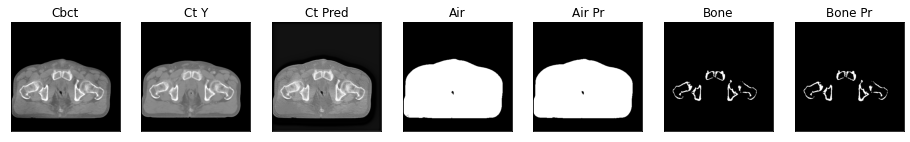

ssim score = 0.40431538224220276
psnr score = 23.664356231689453
snr score = 14.761894226074219
mae error = 0.05009406805038452
air dice score = 0.9989778480507251
bone dice score = 0.9387380296479242


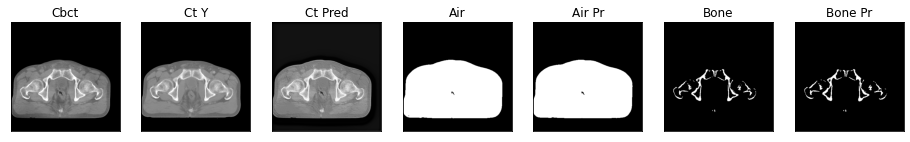

ssim score = 0.40465375781059265
psnr score = 23.587543487548828
snr score = 14.646845817565918
mae error = 0.05033738166093826
air dice score = 0.9990435083150482
bone dice score = 0.9318537487561267


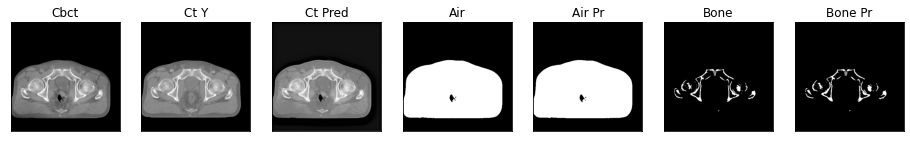

ssim score = 0.39990273118019104
psnr score = 23.238800048828125
snr score = 14.202432632446289
mae error = 0.05138188973069191
air dice score = 0.9987985452656198
bone dice score = 0.9322429906550851


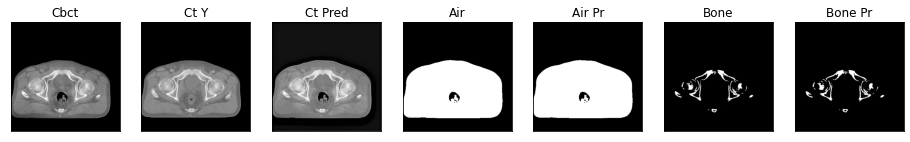

12it [00:26,  2.21s/it]

ssim score = 0.401877760887146
psnr score = 23.10088348388672
snr score = 13.904760360717773
mae error = 0.051621872931718826
air dice score = 0.9983892200390853
bone dice score = 0.9340084939573013


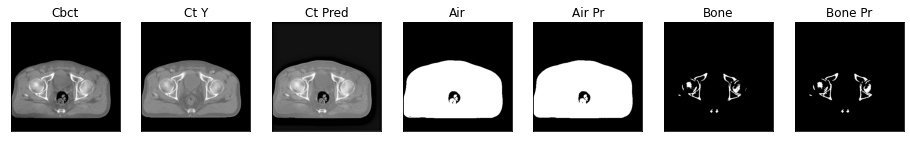

ssim score = 0.3982793390750885
psnr score = 22.879207611083984
snr score = 13.566655158996582
mae error = 0.051994577050209045
air dice score = 0.9987858765228175
bone dice score = 0.9405823935374418


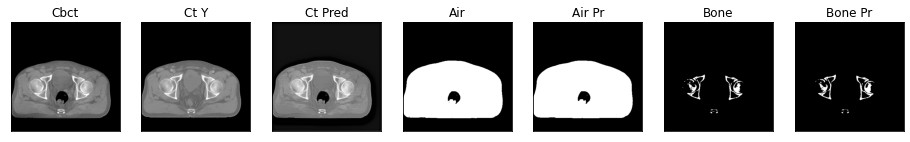

ssim score = 0.39077234268188477
psnr score = 22.808494567871094
snr score = 13.450847625732422
mae error = 0.052067991346120834
air dice score = 0.9987696809483443
bone dice score = 0.9532945431678991


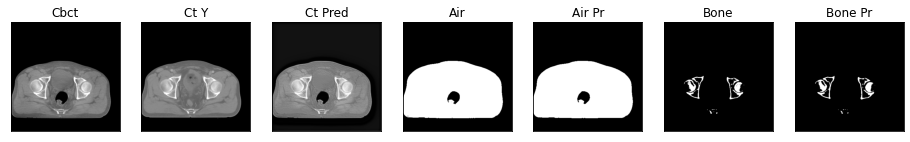

ssim score = 0.38094425201416016
psnr score = 22.439834594726562
snr score = 13.088865280151367
mae error = 0.05372447893023491
air dice score = 0.9985589697883447
bone dice score = 0.962323390895411


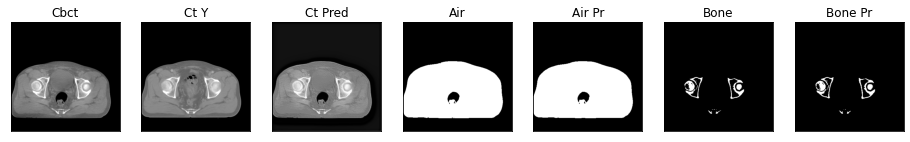

ssim score = 0.37814226746559143
psnr score = 22.175418853759766
snr score = 12.854552268981934
mae error = 0.05483681708574295
air dice score = 0.9987482684380069
bone dice score = 0.9681434286565692


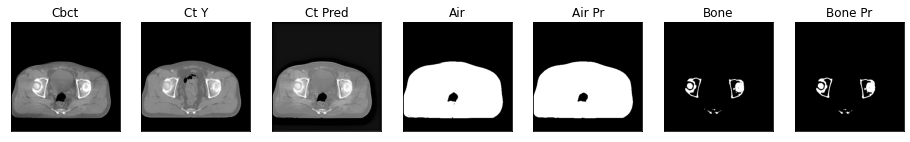

ssim score = 0.3813221752643585
psnr score = 22.59067726135254
snr score = 13.22722339630127
mae error = 0.0540931411087513
air dice score = 0.9987747038867737
bone dice score = 0.9635157545611357


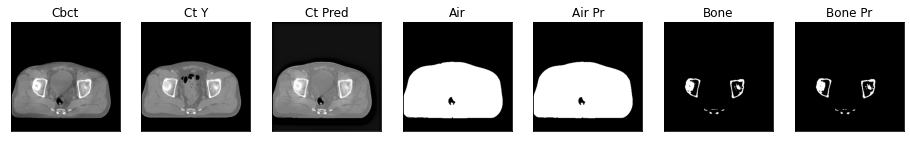

ssim score = 0.37876540422439575
psnr score = 22.738258361816406
snr score = 13.284602165222168
mae error = 0.05315138399600983
air dice score = 0.9986031533603792
bone dice score = 0.9612028958611248


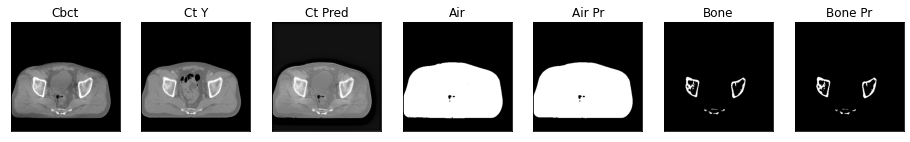

ssim score = 0.3762131631374359
psnr score = 22.51876449584961
snr score = 12.999378204345703
mae error = 0.053385309875011444
air dice score = 0.9987927701282375
bone dice score = 0.9662447257390441


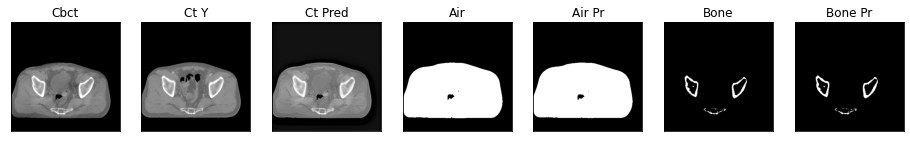

13it [00:29,  2.24s/it]

ssim score = 0.3692336678504944
psnr score = 22.435081481933594
snr score = 12.915395736694336
mae error = 0.053781330585479736
air dice score = 0.9985332992240142
bone dice score = 0.9703037502126199


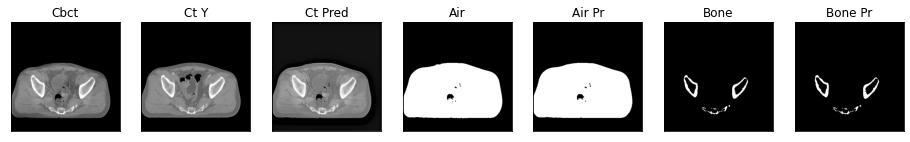

ssim score = 0.36220356822013855
psnr score = 22.344600677490234
snr score = 12.901081085205078
mae error = 0.055001791566610336
air dice score = 0.9984843526635793
bone dice score = 0.9616340049687878


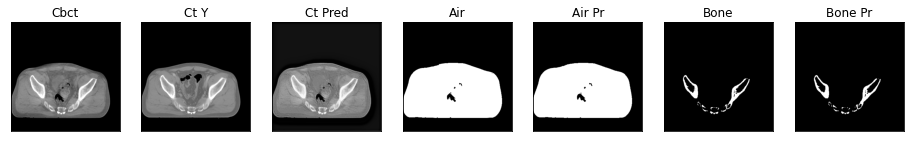

ssim score = 0.3624873757362366
psnr score = 22.48409080505371
snr score = 13.076152801513672
mae error = 0.05444809049367905
air dice score = 0.9976201229892666
bone dice score = 0.9539716945052407


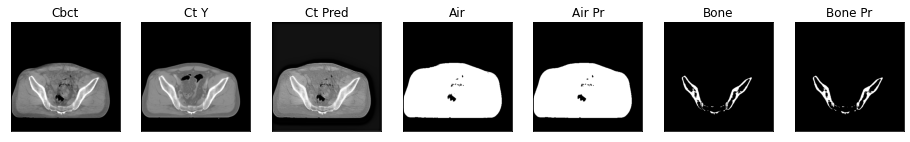

ssim score = 0.35901740193367004
psnr score = 22.81702423095703
snr score = 13.347389221191406
mae error = 0.053565312176942825
air dice score = 0.9977053213858832
bone dice score = 0.9425131881517312


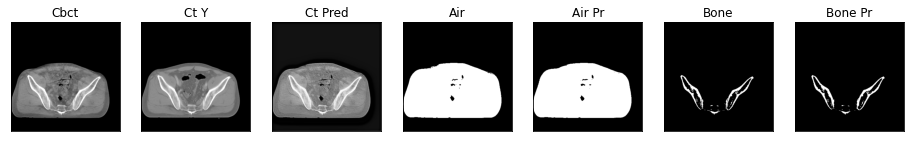

ssim score = 0.34669259190559387
psnr score = 22.58974838256836
snr score = 13.058849334716797
mae error = 0.05465065687894821
air dice score = 0.9973731069621504
bone dice score = 0.941777904005371


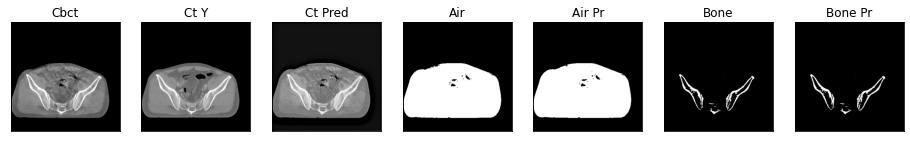

ssim score = 0.42275354266166687
psnr score = 21.01291275024414
snr score = 12.710217475891113
mae error = 0.056192900985479355
air dice score = 0.9993303037550829
bone dice score = 0.9837194740142855


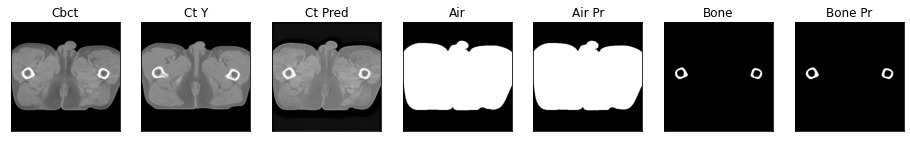

ssim score = 0.4198856055736542
psnr score = 20.803977966308594
snr score = 12.605576515197754
mae error = 0.05661720782518387
air dice score = 0.9994235968743505
bone dice score = 0.9768091645717573


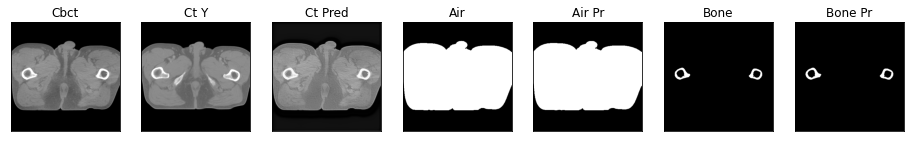

ssim score = 0.4162507951259613
psnr score = 20.653568267822266
snr score = 12.583121299743652
mae error = 0.05785858631134033
air dice score = 0.9994137120319323
bone dice score = 0.9691371930621956


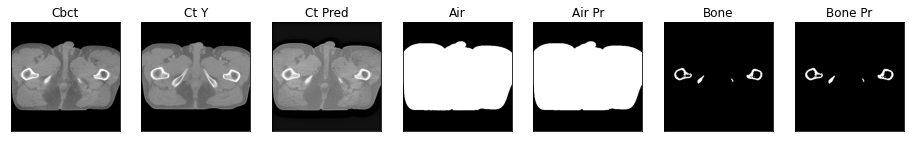

14it [00:31,  2.19s/it]

ssim score = 0.41137728095054626
psnr score = 20.492015838623047
snr score = 12.453859329223633
mae error = 0.05851562321186066
air dice score = 0.9992263672924632
bone dice score = 0.9733576038395936


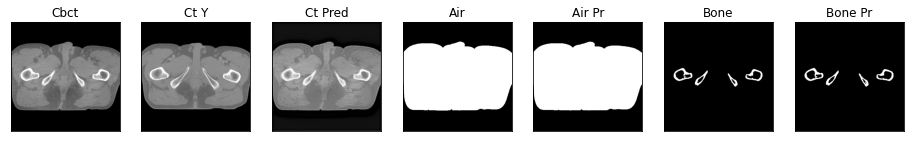

ssim score = 0.3985114097595215
psnr score = 20.429691314697266
snr score = 12.421772003173828
mae error = 0.05932071432471275
air dice score = 0.9991519634402022
bone dice score = 0.9631277813101855


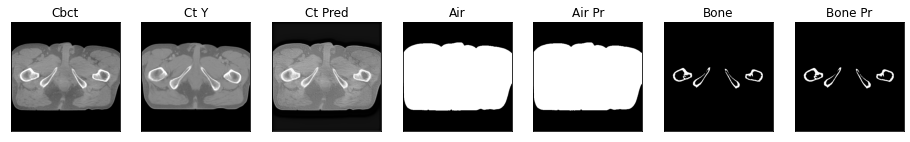

ssim score = 0.3974284529685974
psnr score = 20.310394287109375
snr score = 12.336892127990723
mae error = 0.06068433076143265
air dice score = 0.9990728570087322
bone dice score = 0.9664551223939792


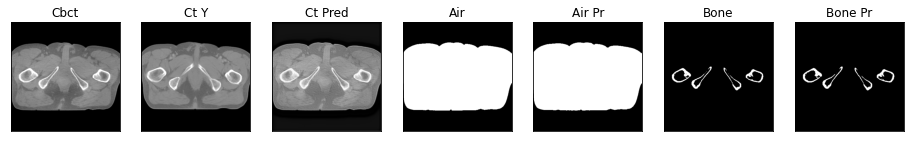

ssim score = 0.38873180747032166
psnr score = 20.084714889526367
snr score = 12.131523132324219
mae error = 0.062085285782814026
air dice score = 0.9987483916247522
bone dice score = 0.9683485631046438


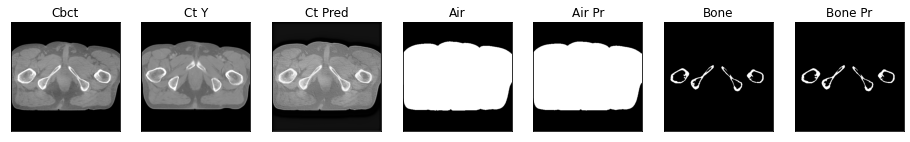

ssim score = 0.3892311155796051
psnr score = 20.166431427001953
snr score = 12.252312660217285
mae error = 0.06109859049320221
air dice score = 0.9993396948572167
bone dice score = 0.9690830153931183


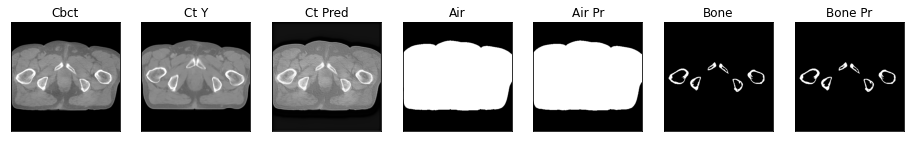

ssim score = 0.3843648433685303
psnr score = 20.303857803344727
snr score = 12.438417434692383
mae error = 0.06086259335279465
air dice score = 0.9994737519149586
bone dice score = 0.9670021658814244


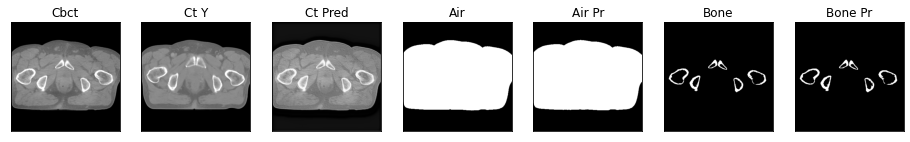

ssim score = 0.38624975085258484
psnr score = 20.243471145629883
snr score = 12.400644302368164
mae error = 0.062081046402454376
air dice score = 0.9994917422724381
bone dice score = 0.9657701711495628


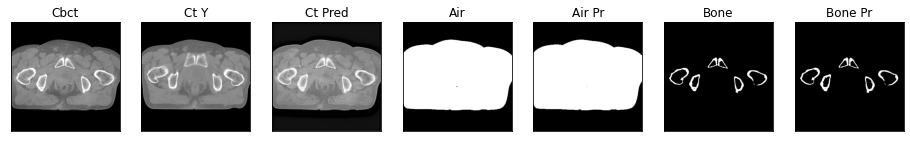

ssim score = 0.37763699889183044
psnr score = 20.143964767456055
snr score = 12.343914031982422
mae error = 0.06313572824001312
air dice score = 0.9995748720248324
bone dice score = 0.9702176403210743


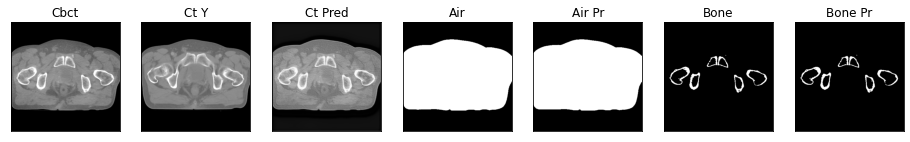

15it [00:33,  2.22s/it]

ssim score = 0.3764019012451172
psnr score = 20.080678939819336
snr score = 12.338967323303223
mae error = 0.06358204782009125
air dice score = 0.9995237652743579
bone dice score = 0.9677822959027444


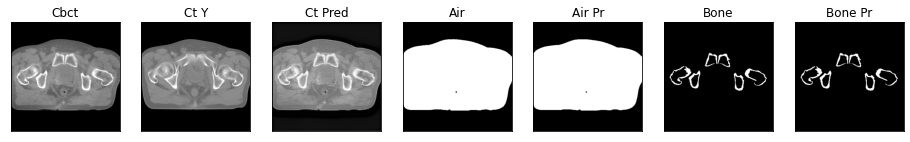

ssim score = 0.367857426404953
psnr score = 19.85359001159668
snr score = 12.036505699157715
mae error = 0.065443255007267
air dice score = 0.9994724056562755
bone dice score = 0.959797106894986


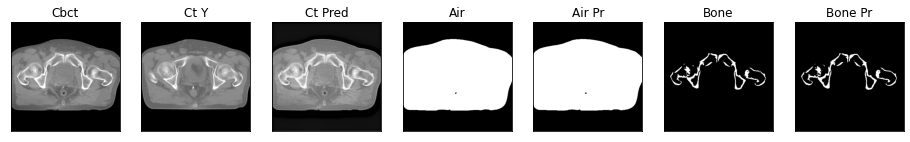

ssim score = 0.3729504346847534
psnr score = 19.728225708007812
snr score = 11.803927421569824
mae error = 0.06629519164562225
air dice score = 0.9993563836880958
bone dice score = 0.9530877771673714


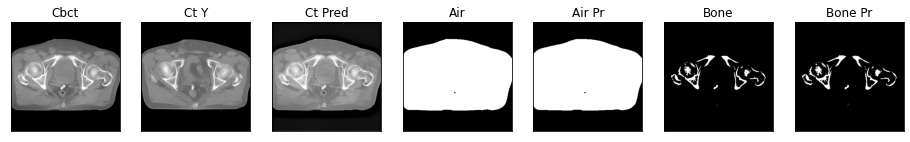

ssim score = 0.3863198459148407
psnr score = 19.8302001953125
snr score = 11.78281307220459
mae error = 0.0656299963593483
air dice score = 0.9993443383910184
bone dice score = 0.9533530307104185


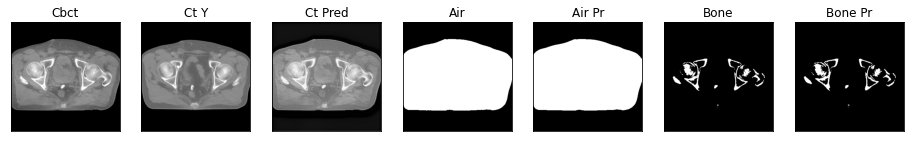

ssim score = 0.3913990557193756
psnr score = 19.96360969543457
snr score = 11.803791046142578
mae error = 0.06442008167505264
air dice score = 0.9993254088255139
bone dice score = 0.9622659443022311


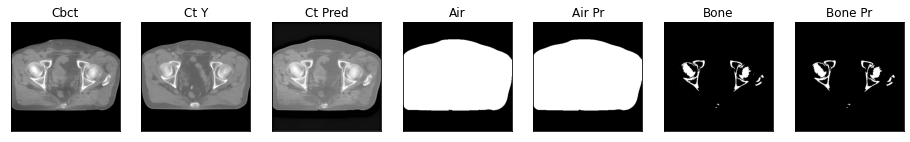

ssim score = 0.3871532380580902
psnr score = 20.18014907836914
snr score = 11.969682693481445
mae error = 0.06208621338009834
air dice score = 0.9993468168987804
bone dice score = 0.9698694670726287


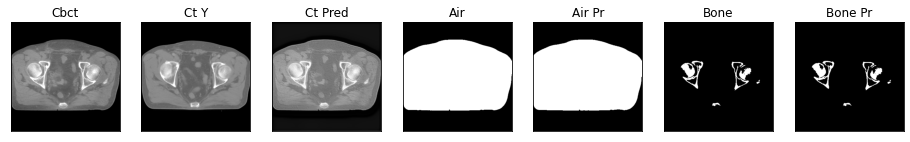

ssim score = 0.38805705308914185
psnr score = 20.059406280517578
snr score = 11.881093978881836
mae error = 0.06306931376457214
air dice score = 0.9993387365772307
bone dice score = 0.9658567239215976


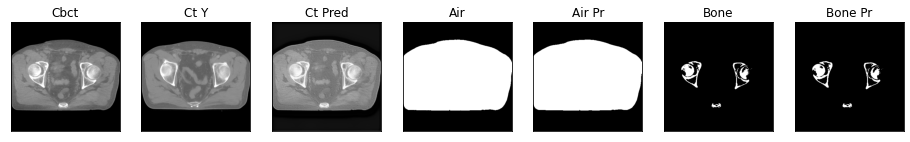

ssim score = 0.3817402124404907
psnr score = 19.84626007080078
snr score = 11.681427001953125
mae error = 0.06465792655944824
air dice score = 0.9993241932924719
bone dice score = 0.9668558456303422


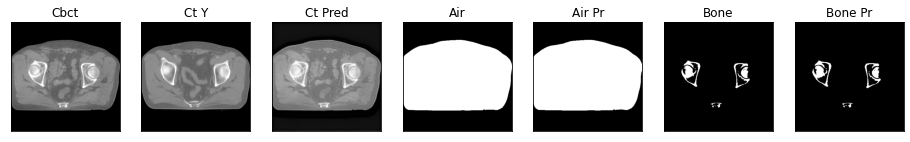

16it [00:35,  2.18s/it]

ssim score = 0.37711387872695923
psnr score = 19.563222885131836
snr score = 11.256898880004883
mae error = 0.06646037101745605
air dice score = 0.9995331824547514
bone dice score = 0.9744170251304685


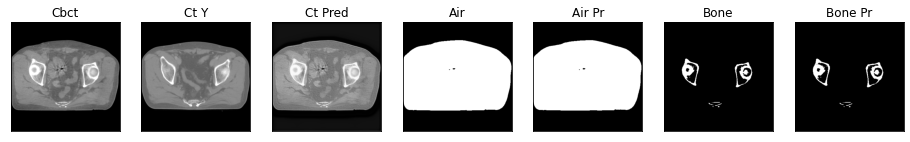

ssim score = 0.3870486617088318
psnr score = 19.59317970275879
snr score = 11.227544784545898
mae error = 0.06616883724927902
air dice score = 0.9995368336045036
bone dice score = 0.9692877945463425


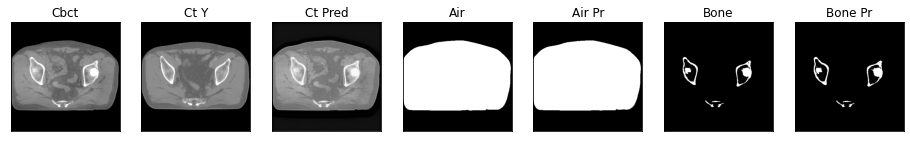

ssim score = 0.38275885581970215
psnr score = 19.793060302734375
snr score = 11.45307445526123
mae error = 0.0642203763127327
air dice score = 0.9994450577318976
bone dice score = 0.955967976711136


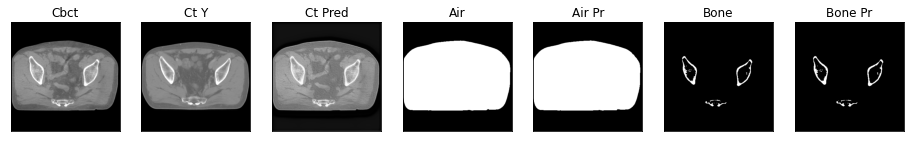

ssim score = 0.37366724014282227
psnr score = 19.68853759765625
snr score = 11.421365737915039
mae error = 0.06499231606721878
air dice score = 0.9994475403535745
bone dice score = 0.9557251908404457


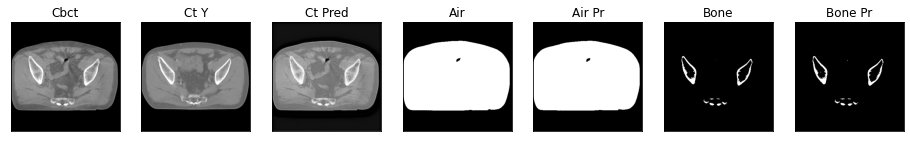

ssim score = 0.3651302754878998
psnr score = 19.421142578125
snr score = 11.283199310302734
mae error = 0.0666191577911377
air dice score = 0.9993110700170423
bone dice score = 0.963691136832667


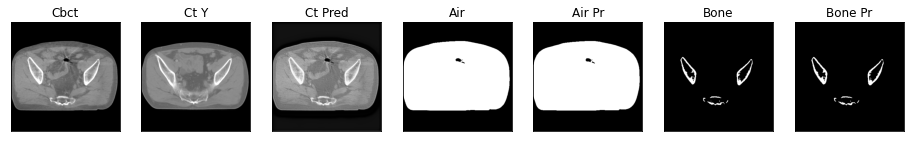

ssim score = 0.36031395196914673
psnr score = 19.320106506347656
snr score = 11.216124534606934
mae error = 0.06742802262306213
air dice score = 0.9993860966077283
bone dice score = 0.9642189969828392


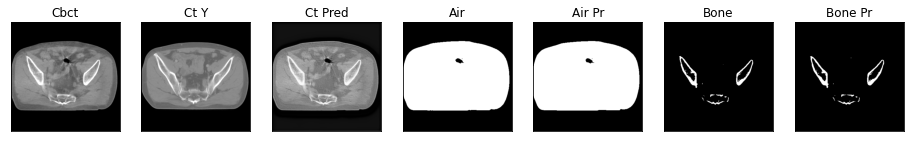

ssim score = 0.35027939081192017
psnr score = 19.283851623535156
snr score = 11.150078773498535
mae error = 0.06847896426916122
air dice score = 0.9993357101502274
bone dice score = 0.9622049075478287


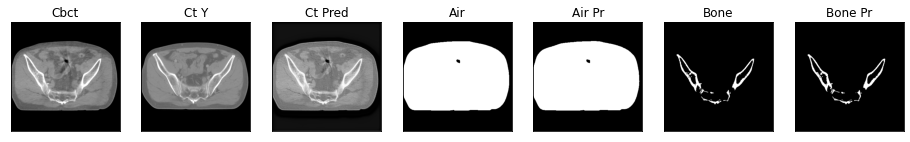

ssim score = 0.34995999932289124
psnr score = 19.413297653198242
snr score = 11.216150283813477
mae error = 0.0674804225564003
air dice score = 0.9992852823134866
bone dice score = 0.9543109801037299


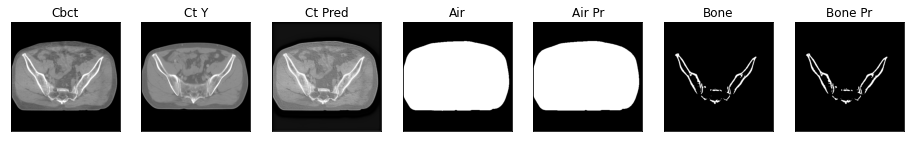

17it [00:37,  2.22s/it]

ssim score = 0.3812042474746704
psnr score = 21.69200897216797
snr score = 13.169401168823242
mae error = 0.0607142448425293
air dice score = 0.9987306499222627
bone dice score = 0.9545560475418952


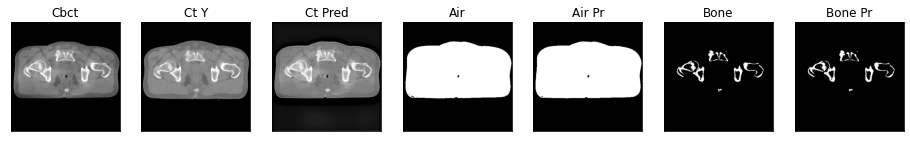

ssim score = 0.3877265751361847
psnr score = 21.894771575927734
snr score = 13.412178039550781
mae error = 0.059261567890644073
air dice score = 0.9986985337817007
bone dice score = 0.9468354430386156


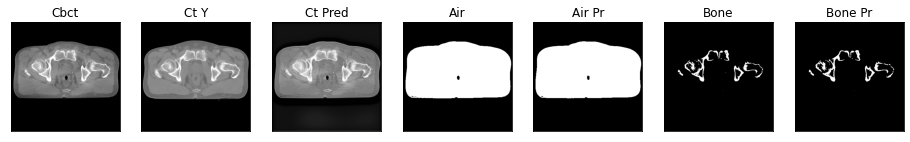

ssim score = 0.3885403871536255
psnr score = 22.069807052612305
snr score = 13.594998359680176
mae error = 0.058669913560152054
air dice score = 0.9989682414164471
bone dice score = 0.9343249716382916


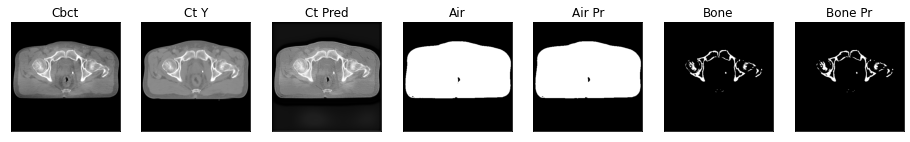

ssim score = 0.39488527178764343
psnr score = 22.21719741821289
snr score = 13.683968544006348
mae error = 0.05701553076505661
air dice score = 0.9990407492730096
bone dice score = 0.9384505703429366


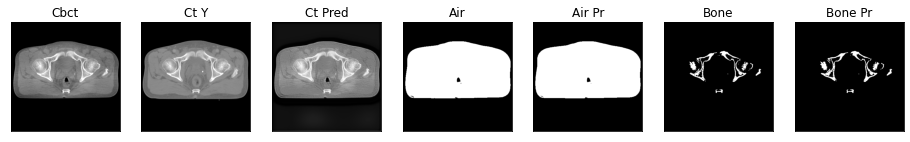

ssim score = 0.4004104733467102
psnr score = 22.31926727294922
snr score = 13.630413055419922
mae error = 0.05603259056806564
air dice score = 0.9989696657474477
bone dice score = 0.9317592859209364


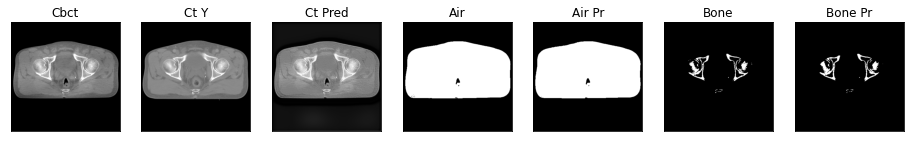

ssim score = 0.40336284041404724
psnr score = 22.40201759338379
snr score = 13.692359924316406
mae error = 0.055736739188432693
air dice score = 0.9990884229717418
bone dice score = 0.9444217964404888


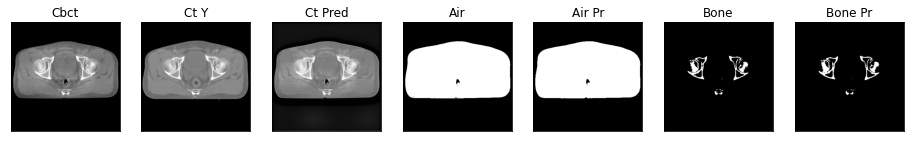

ssim score = 0.39232930541038513
psnr score = 22.365320205688477
snr score = 13.640031814575195
mae error = 0.056015219539403915
air dice score = 0.9987114679353761
bone dice score = 0.9514511167587073


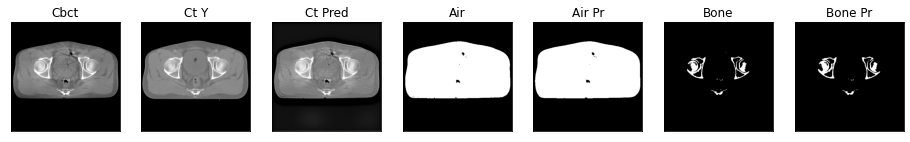

ssim score = 0.38346853852272034
psnr score = 21.951942443847656
snr score = 13.236019134521484
mae error = 0.05777634680271149
air dice score = 0.9989196809611017
bone dice score = 0.9570354457578272


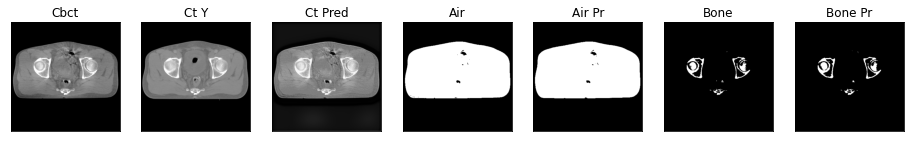

18it [00:40,  2.18s/it]

ssim score = 0.3732035458087921
psnr score = 21.908588409423828
snr score = 13.248444557189941
mae error = 0.05858607962727547
air dice score = 0.9980683243675894
bone dice score = 0.9643374128179453


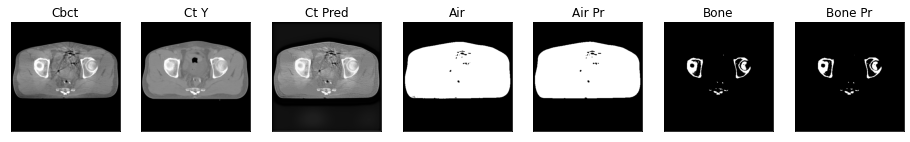

ssim score = 0.374053031206131
psnr score = 21.692514419555664
snr score = 13.010443687438965
mae error = 0.059181537479162216
air dice score = 0.998142156027931
bone dice score = 0.9614920166381122


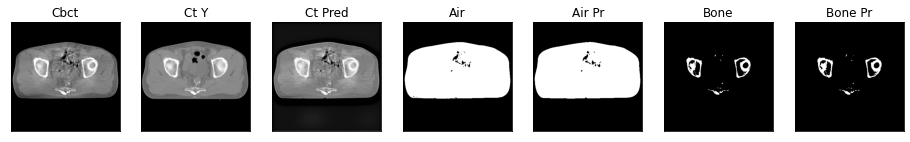

ssim score = 0.3730820417404175
psnr score = 21.275371551513672
snr score = 12.522527694702148
mae error = 0.05969047546386719
air dice score = 0.99809754544537
bone dice score = 0.9564831261107685


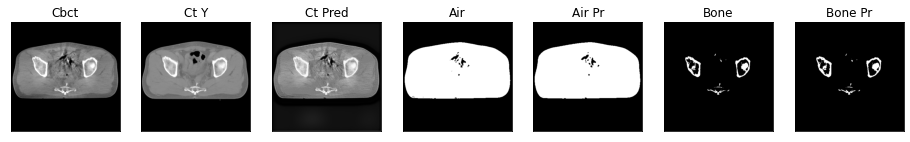

ssim score = 0.3762880563735962
psnr score = 21.51515769958496
snr score = 12.718419075012207
mae error = 0.05875637009739876
air dice score = 0.9984329423446918
bone dice score = 0.9529094656738083


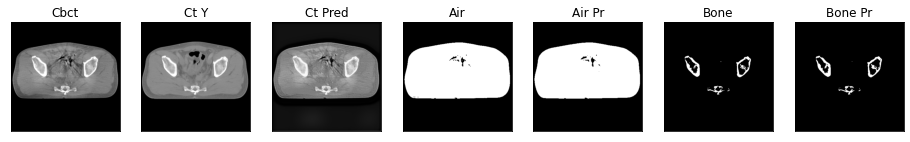

ssim score = 0.37564826011657715
psnr score = 21.754758834838867
snr score = 12.956923484802246
mae error = 0.05785342678427696
air dice score = 0.998381070983812
bone dice score = 0.9582689335400577


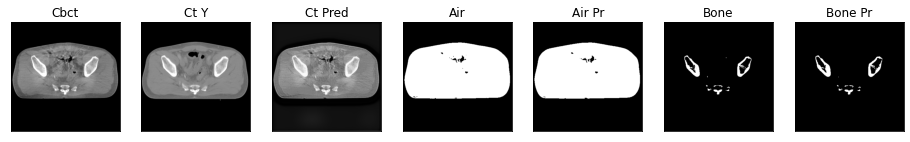

ssim score = 0.37237218022346497
psnr score = 21.80575180053711
snr score = 13.021273612976074
mae error = 0.05793677642941475
air dice score = 0.9982434678962405
bone dice score = 0.9638235294122968


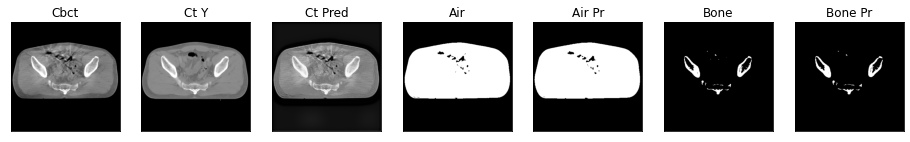

ssim score = 0.36720991134643555
psnr score = 21.77349090576172
snr score = 13.044214248657227
mae error = 0.05838651955127716
air dice score = 0.997810609879034
bone dice score = 0.9633996561046009


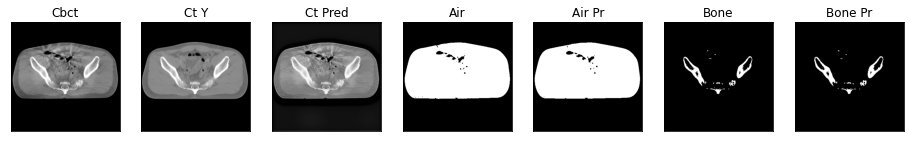

ssim score = 0.36875462532043457
psnr score = 21.407264709472656
snr score = 12.697361946105957
mae error = 0.05870737507939339
air dice score = 0.9980834601825066
bone dice score = 0.9542892924238662


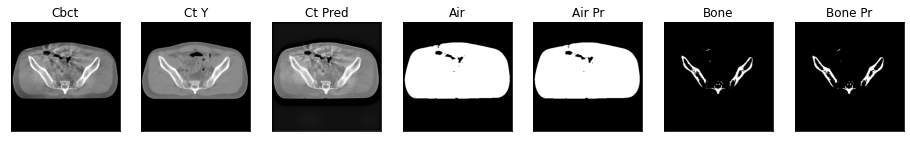

19it [00:42,  2.21s/it]

ssim score = 0.37405258417129517
psnr score = 21.50650405883789
snr score = 12.741862297058105
mae error = 0.057424623519182205
air dice score = 0.9980603958054104
bone dice score = 0.9486013504209921


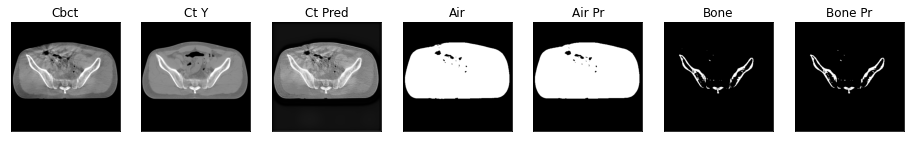

ssim score = 0.376498281955719
psnr score = 21.75338363647461
snr score = 12.952385902404785
mae error = 0.05667154863476753
air dice score = 0.9982463176602903
bone dice score = 0.9458752237991203


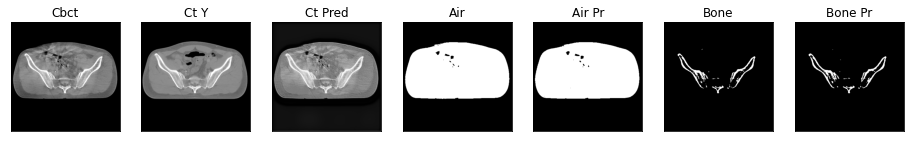

ssim score = 0.37921473383903503
psnr score = 21.92892837524414
snr score = 13.128003120422363
mae error = 0.05559350922703743
air dice score = 0.9983563884585454
bone dice score = 0.9411322645297955


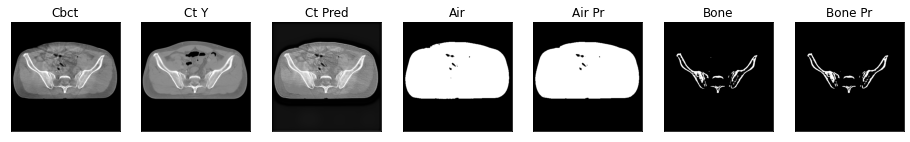

ssim score = 0.37743499875068665
psnr score = 22.012479782104492
snr score = 13.21013355255127
mae error = 0.055436260998249054
air dice score = 0.9984155137755718
bone dice score = 0.9473684210532943


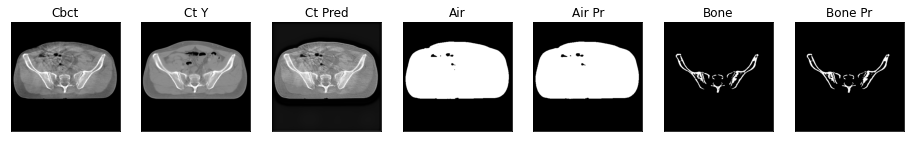

ssim score = 0.36997371912002563
psnr score = 21.606464385986328
snr score = 12.809157371520996
mae error = 0.056540004909038544
air dice score = 0.998246184856879
bone dice score = 0.945675040218467


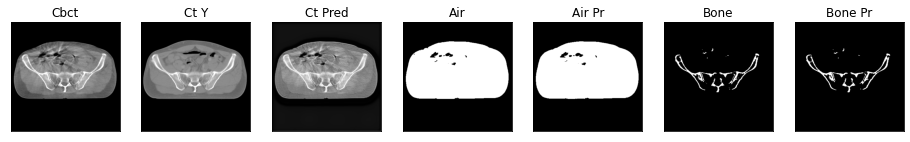

ssim score = 0.3644751310348511
psnr score = 21.30120849609375
snr score = 12.486628532409668
mae error = 0.057571835815906525
air dice score = 0.9980820866896831
bone dice score = 0.9452577192773373


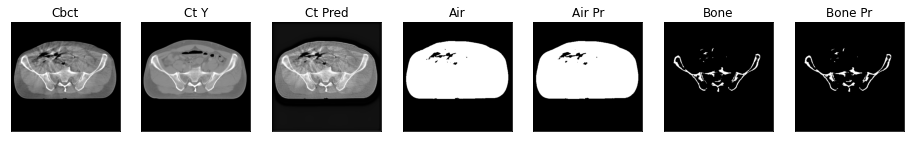

ssim score = 0.3590255379676819
psnr score = 21.022785186767578
snr score = 12.189579963684082
mae error = 0.05861575901508331
air dice score = 0.9980035759242497
bone dice score = 0.9472830494734412


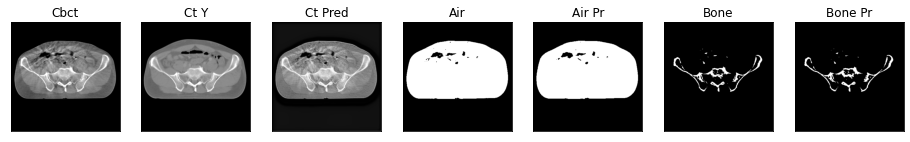

ssim score = 0.3502534329891205
psnr score = 20.68218994140625
snr score = 11.803047180175781
mae error = 0.06013399362564087
air dice score = 0.9978341559246723
bone dice score = 0.9401345291486533


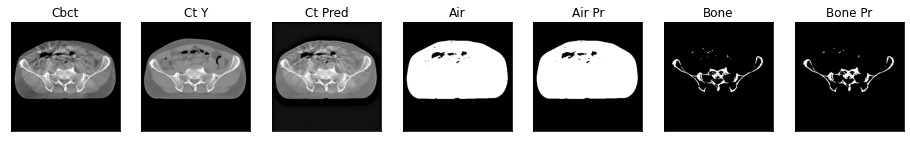

20it [00:44,  2.24s/it]

ssim score = 0.3439445197582245
psnr score = 20.66055679321289
snr score = 11.727618217468262
mae error = 0.06063803657889366
air dice score = 0.9981551606952146
bone dice score = 0.9523287671238101


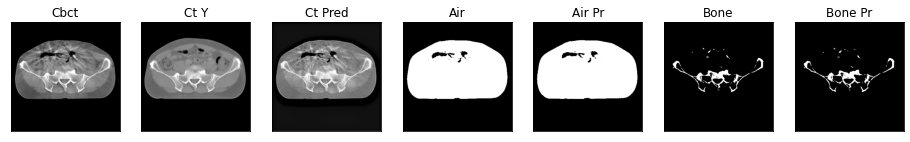

ssim score = 0.337552011013031
psnr score = 20.37746810913086
snr score = 11.474991798400879
mae error = 0.06258567422628403
air dice score = 0.9979047557172575
bone dice score = 0.9523707128270898


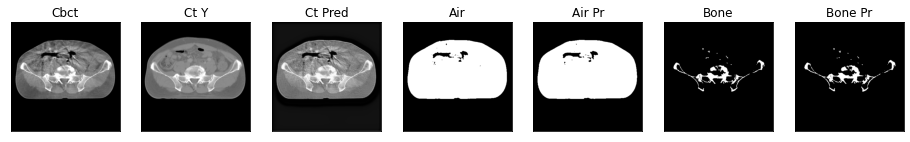

ssim score = 0.3270794451236725
psnr score = 20.16400909423828
snr score = 11.206306457519531
mae error = 0.06333217769861221
air dice score = 0.9979588019549978
bone dice score = 0.9467589964814762


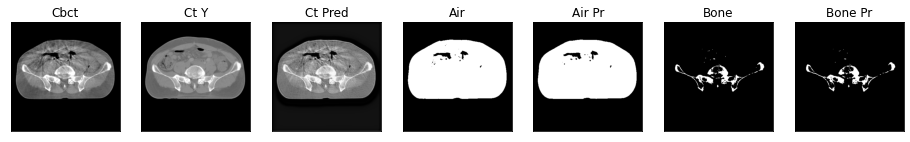

ssim score = 0.32943975925445557
psnr score = 20.757469177246094
snr score = 11.652235984802246
mae error = 0.060652442276477814
air dice score = 0.9980103785153379
bone dice score = 0.9538313946521905


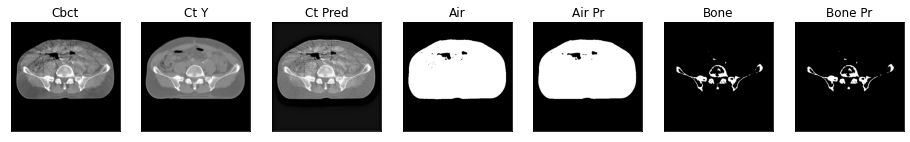

ssim score = 0.41416069865226746
psnr score = 23.552778244018555
snr score = 13.933691024780273
mae error = 0.04955257102847099
air dice score = 0.9992303956364186
bone dice score = 0.9722976643136259


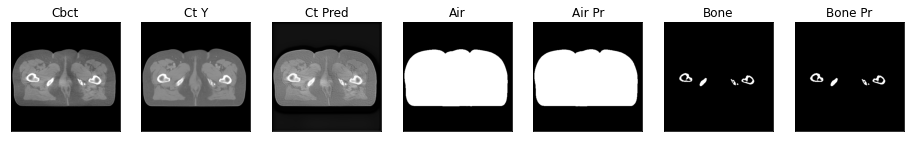

ssim score = 0.41720736026763916
psnr score = 23.61469268798828
snr score = 14.116617202758789
mae error = 0.04959464445710182
air dice score = 0.9991983134891185
bone dice score = 0.9769797421736423


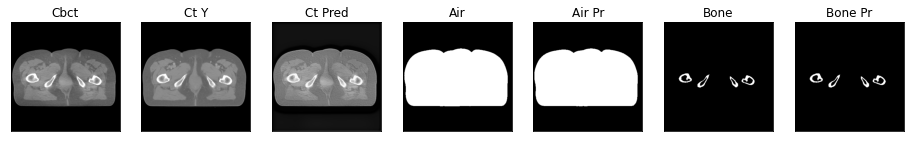

ssim score = 0.4166816174983978
psnr score = 23.603404998779297
snr score = 14.18824577331543
mae error = 0.049715567380189896
air dice score = 0.9992103845501042
bone dice score = 0.9633140972802284


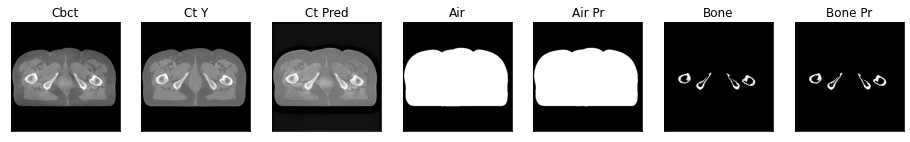

ssim score = 0.41780999302864075
psnr score = 23.593860626220703
snr score = 14.242147445678711
mae error = 0.04974992945790291
air dice score = 0.9991995829019165
bone dice score = 0.9577155409123611


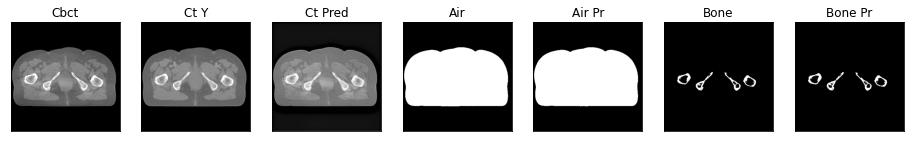

21it [00:46,  2.19s/it]

ssim score = 0.4196021854877472
psnr score = 23.540170669555664
snr score = 14.2169189453125
mae error = 0.049987535923719406
air dice score = 0.9990995541695041
bone dice score = 0.9666258955099314


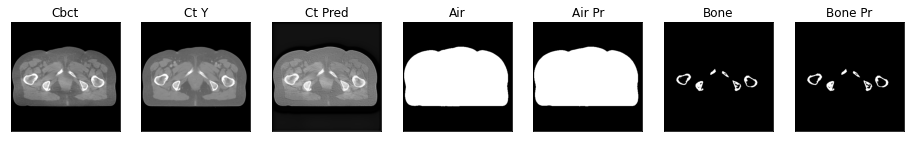

ssim score = 0.42203083634376526
psnr score = 23.531625747680664
snr score = 14.231328964233398
mae error = 0.04979242756962776
air dice score = 0.9991238317757015
bone dice score = 0.960566963475185


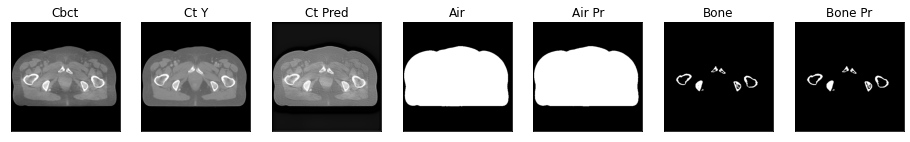

ssim score = 0.4191504120826721
psnr score = 23.485244750976562
snr score = 14.216276168823242
mae error = 0.050003111362457275
air dice score = 0.9990675447287145
bone dice score = 0.9599001960442006


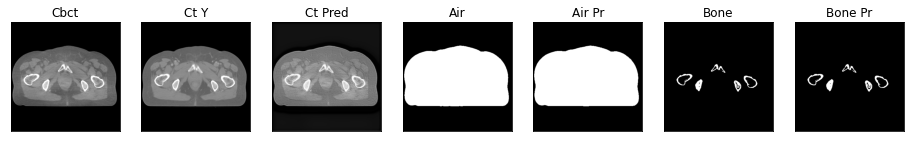

ssim score = 0.4190860092639923
psnr score = 23.348360061645508
snr score = 14.127755165100098
mae error = 0.050535447895526886
air dice score = 0.9989291880039927
bone dice score = 0.9643231899271717


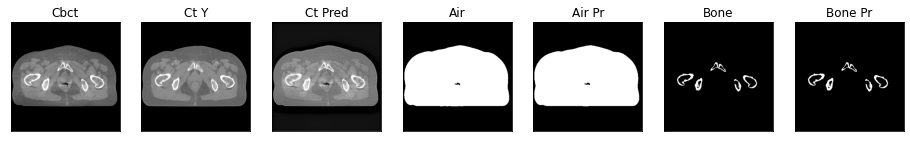

ssim score = 0.41805386543273926
psnr score = 23.205062866210938
snr score = 14.027199745178223
mae error = 0.050512079149484634
air dice score = 0.9992058461381542
bone dice score = 0.9564650252738225


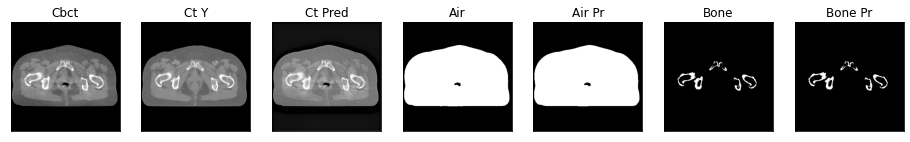

ssim score = 0.4190824329853058
psnr score = 23.15704345703125
snr score = 14.066882133483887
mae error = 0.05064891651272774
air dice score = 0.9991910505411222
bone dice score = 0.9564853556491425


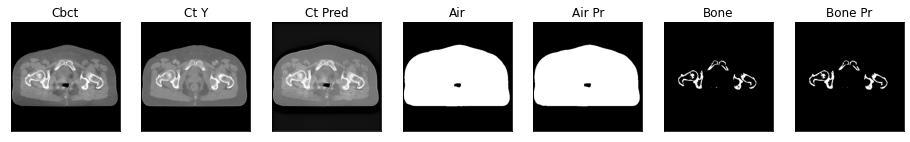

ssim score = 0.4229603707790375
psnr score = 23.65911293029785
snr score = 14.682225227355957
mae error = 0.04988566413521767
air dice score = 0.9991367866702459
bone dice score = 0.9572137008423802


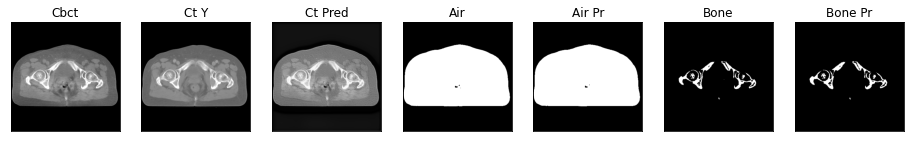

ssim score = 0.4280439615249634
psnr score = 23.338150024414062
snr score = 14.232712745666504
mae error = 0.049797963351011276
air dice score = 0.9989090274343242
bone dice score = 0.9487906588832562


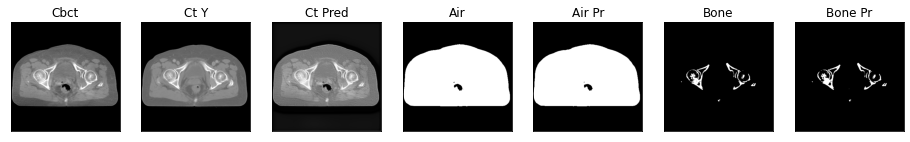

22it [00:48,  2.22s/it]

ssim score = 0.4304657280445099
psnr score = 23.563579559326172
snr score = 14.348721504211426
mae error = 0.048591677099466324
air dice score = 0.9989251372628773
bone dice score = 0.9419500281806885


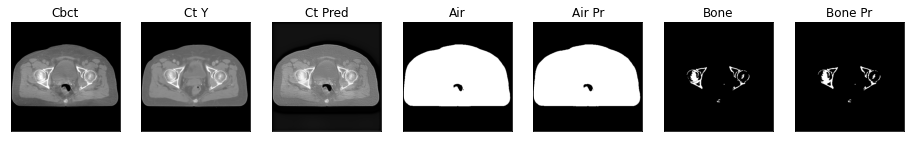

ssim score = 0.43020832538604736
psnr score = 23.562143325805664
snr score = 14.32015323638916
mae error = 0.048787880688905716
air dice score = 0.9990445168295338
bone dice score = 0.9496961512500052


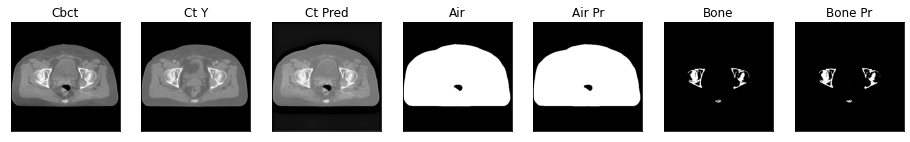

ssim score = 0.4371207654476166
psnr score = 23.907516479492188
snr score = 14.657524108886719
mae error = 0.048406194895505905
air dice score = 0.9990313901345298
bone dice score = 0.9575302188834118


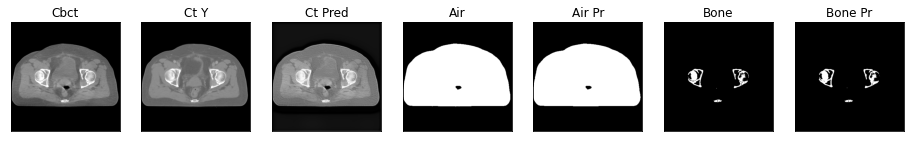

ssim score = 0.4377721846103668
psnr score = 24.209720611572266
snr score = 14.99395751953125
mae error = 0.04780295863747597
air dice score = 0.9991756211268412
bone dice score = 0.9673692427795884


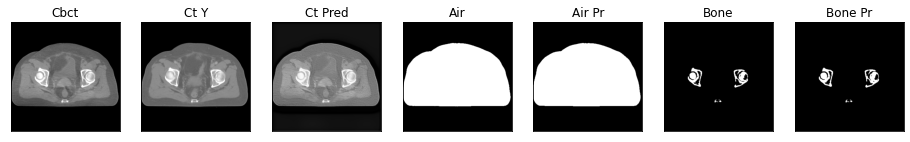

ssim score = 0.4379017949104309
psnr score = 23.79692268371582
snr score = 14.63265323638916
mae error = 0.04896240308880806
air dice score = 0.998956217558114
bone dice score = 0.969934231131069


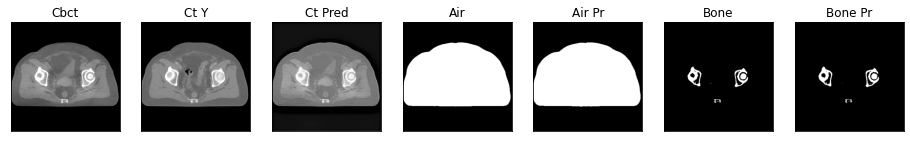

ssim score = 0.4311831295490265
psnr score = 23.25719451904297
snr score = 14.130477905273438
mae error = 0.05036233738064766
air dice score = 0.9989721501639672
bone dice score = 0.9720040969618982


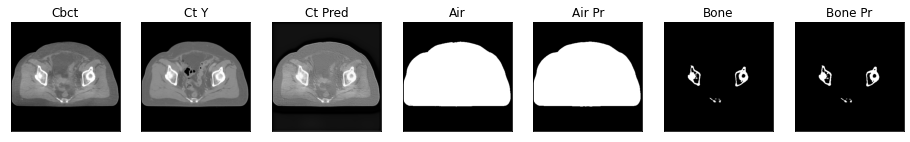

ssim score = 0.4170936346054077
psnr score = 22.2240047454834
snr score = 13.024852752685547
mae error = 0.05325953662395477
air dice score = 0.9987057448229802
bone dice score = 0.9607370037297491


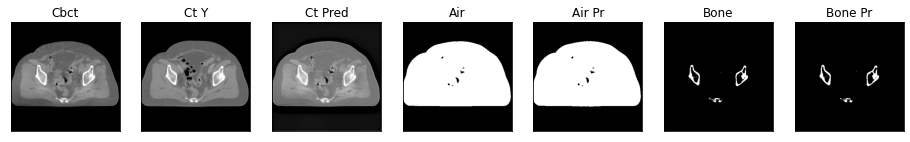

ssim score = 0.4086790382862091
psnr score = 21.992183685302734
snr score = 12.775040626525879
mae error = 0.05415207892656326
air dice score = 0.9985256556679205
bone dice score = 0.970218398412305


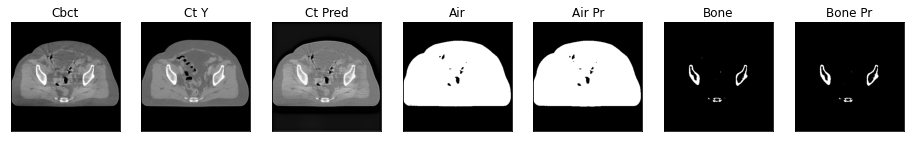

23it [00:51,  2.17s/it]

ssim score = 0.4088982939720154
psnr score = 22.397911071777344
snr score = 13.24567985534668
mae error = 0.05303573235869408
air dice score = 0.998410501651161
bone dice score = 0.9737288135598786


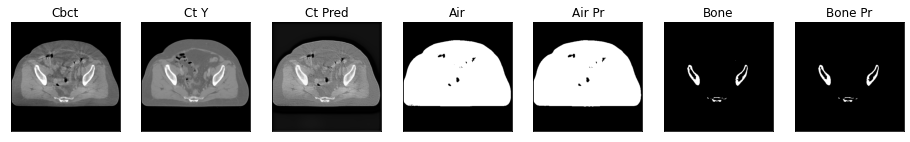

ssim score = 0.4150196611881256
psnr score = 22.530216217041016
snr score = 13.433082580566406
mae error = 0.05255226045846939
air dice score = 0.9986209145442574
bone dice score = 0.9695755146662494


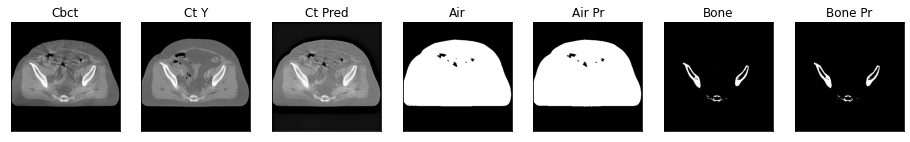

ssim score = 0.41704490780830383
psnr score = 22.16529083251953
snr score = 13.132587432861328
mae error = 0.05328557267785072
air dice score = 0.9987826613310026
bone dice score = 0.9648164998488805


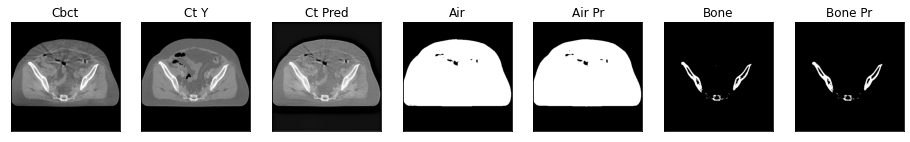

ssim score = 0.41523006558418274
psnr score = 22.0504150390625
snr score = 13.090568542480469
mae error = 0.0535372719168663
air dice score = 0.9984386468272514
bone dice score = 0.9601788458857038


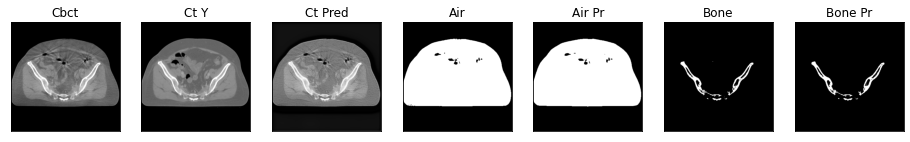

ssim score = 0.4211667478084564
psnr score = 22.00763511657715
snr score = 13.043499946594238
mae error = 0.0536743588745594
air dice score = 0.9986162514317504
bone dice score = 0.941325811002238


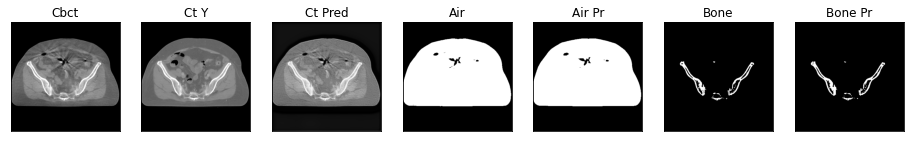

ssim score = 0.42215612530708313
psnr score = 21.990270614624023
snr score = 13.003958702087402
mae error = 0.05354158207774162
air dice score = 0.9984086548221699
bone dice score = 0.9459681843123153


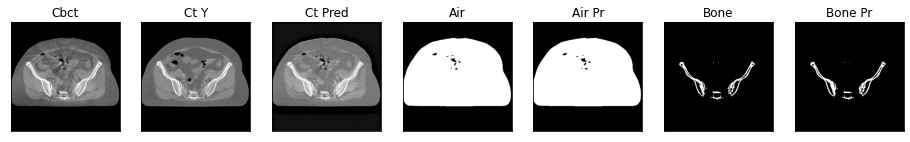

ssim score = 0.43567609786987305
psnr score = 22.57575035095215
snr score = 13.601070404052734
mae error = 0.051447853446006775
air dice score = 0.9987753277132331
bone dice score = 0.9545980335460584


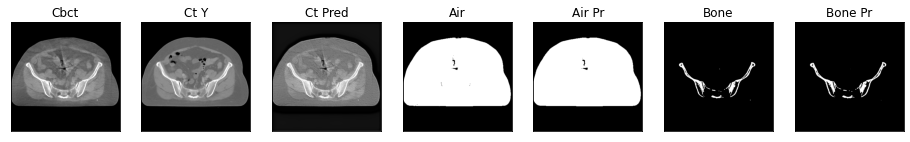

24it [00:53,  2.22s/it]


In [32]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [33]:
discriminator = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=DIS_IN_CHANNELS, classes=DIS_N_CLASSES)
discriminator = Discriminator(encoder=discriminator.encoder, hidden_ch=2048, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [34]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [35]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:07,  3.41it/s]


(0.37701282898585003,
 21.82872462272644,
 12.843295375506083,
 0.05675781254346172,
 0.9982222058751992,
 0.9605769234621562,
 0.3333333333333333)